<a href="https://colab.research.google.com/github/sgr1118/ICR_kaggle_Challenge/blob/main/%5BFlib01%5DICR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 구글 API 불러오기
!pip install kaggle
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rlfkr1234","key":"245b67c294d4315de97f5683b691bb30"}'}

In [ ]:
!ls -1ha kaggle.json
# kaggle json 파일 업로드 확인

kaggle.json


In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning 방지
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c icr-identify-age-related-conditions

  0% 0.00/150k [00:00<?, ?B/s]
100% 150k/150k [00:00<00:00, 88.1MB/s]


In [ ]:
!ls

drive  icr-identify-age-related-conditions.zip	kaggle.json  sample_data


In [4]:
# 불러온 파일이 알집인 경우
!unzip /content/icr-identify-age-related-conditions.zip

Archive:  /content/icr-identify-age-related-conditions.zip
  inflating: greeks.csv              
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
# !unzip /content/train.tsv.zip

Archive:  /content/train.tsv.zip
  inflating: train.tsv               


In [ ]:
# !unzip /content/test.tsv.zip

Archive:  /content/test.tsv.zip
  inflating: test.tsv                


# Import required libraries

In [ ]:
# category-encoders install
!pip install category-encoders

In [ ]:
!pip install optuna

In [ ]:
!pip install catboost

In [8]:
# 라이브러리 불러오기

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
from copy import deepcopy
from functools import partial
import random
import gc

# Import sklearn classes for model selection, cross validation, and performance evaluation
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from category_encoders import OneHotEncoder, OrdinalEncoder, CountEncoder
from imblearn.under_sampling import RandomUnderSampler

# Import libraries for Hypertuning
import optuna

# Import libraries for gradient boosting
import xgboost as xgb
import lightgbm as lgb
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.svm import NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from catboost import CatBoost, CatBoostRegressor, CatBoostClassifier
from catboost import Pool

# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# EDA

In [ ]:
# 데이터 불러오기 및 범주형 변수 변환

df_train = pd.read_csv('/content/train.csv', index_col = [0]) # 첫 번째 col을 index로 사용한다.
df_test = pd.read_csv('/content/test.csv', index_col = [0])
greeks = pd.read_csv('/content/greeks.csv')
df_train['EJ'] = df_train['EJ'].replace({'A' : 0, 'B' : 1})
df_test['EJ'] = df_test['EJ'].replace({'A' : 0, 'B' : 1})

data = pd.concat([df_train, greeks.set_index('Id')], axis=1)
target_col = 'Class'

In [ ]:
data

AB          AF          AH          AM         AR  \
Id                                                                      
000ff2bfdfe9  0.209377  3109.03329   85.200147   22.394407   8.138688   
007255e47698  0.145282   978.76416   85.200147   36.968889   8.138688   
013f2bd269f5  0.470030  2635.10654   85.200147   32.360553   8.138688   
043ac50845d5  0.252107  3819.65177  120.201618   77.112203   8.138688   
044fb8a146ec  0.380297  3733.04844   85.200147   14.103738   8.138688   
...                ...         ...         ...         ...        ...   
fd3dafe738fd  0.149555  3130.05946  123.763599    9.513984  13.020852   
fd895603f071  0.435846  5462.03438   85.200147   46.551007  15.973224   
fd8ef6377f76  0.427300  2459.10720  130.138587   55.355778  10.005552   
fe1942975e40  0.363205  1263.53524   85.200147   23.685856   8.138688   
ffcca4ded3bb  0.482849  2672.53426  546.663930  112.006102   8.138688   

                    AX        AY         AZ          BC         BD   ...  \
Id                                                                   ...   
000ff2bfdfe9  0.699861  0.025578   9.812214    5.555634  4126.58731  ...   
007255e47698  3.632190  0.025578  13.517790    1.229900  5496.92824  ...   
013f2bd269f5  6.732840  0.025578  12.824570    1.229900  5135.78024  ...   
043ac50845d5  3.685344  0.025578  11.053708    1.229900  4169.67738  ...   
044fb8a146ec  3.942255  0.054810   3.396778  102.151980  5728.73412  ...   
...                ...       ...        ...         ...         ...  ...   
fd3dafe738fd  3.499305  0.077343   8.545512    2.804172  4157.68439  ...   
fd895603f071  5.979825  0.025882  12.622906    3.777550  5654.07556  ...   
fd8ef6377f76  8.070549  0.025578  15.408390    1.229900  5888.87769  ...   
fe1942975e40  7.981959  0.025578   7.524588    1.229900  4517.86560  ...   
ffcca4ded3bb  3.198099  0.116928   3.396778    7.948668  2818.01707  ...   

                        GF         GH          GI         GL  Class  Alpha  \
Id                                                                           
000ff2bfdfe9   2003.810319  22.136229   69.834944   0.120343      1      B   
007255e47698  27981.562750  29.135430   32.131996  21.978000      0      A   
013f2bd269f5  13676.957810  28.022851   35.192676   0.196941      0      A   
043ac50845d5   2094.262452  39.948656   90.493248   0.155829      0      A   
044fb8a146ec   8524.370502  45.381316   36.262628   0.096614      1      D   
...                    ...        ...         ...        ...    ...    ...   
fd3dafe738fd   8095.932828  24.640462   69.191944  21.978000      0      A   
fd895603f071   3085.308063  29.648928  124.808872   0.145340      0      A   
fd8ef6377f76   6474.652866  26.166072  119.559420  21.978000      0      A   
fe1942975e40   1965.343176  25.116750   37.155112   0.184622      0      A   
ffcca4ded3bb   6850.484442  45.745974  114.842372  21.978000      0      A   

              Beta  Gamma  Delta    Epsilon  
Id                                           
000ff2bfdfe9     C      G      D  3/19/2019  
007255e47698     C      M      B    Unknown  
013f2bd269f5     C      M      B    Unknown  
043ac50845d5     C      M      B    Unknown  
044fb8a146ec     B      F      B  3/25/2020  
...            ...    ...    ...        ...  
fd3dafe738fd     B      M      B  9/13/2020  
fd895603f071     B      M      B   9/8/2020  
fd8ef6377f76     C      M      B  7/24/2019  
fe1942975e40     C      M      B  1/31/2019  
ffcca4ded3bb     C      M      B    Unknown  

[617 rows x 62 columns]

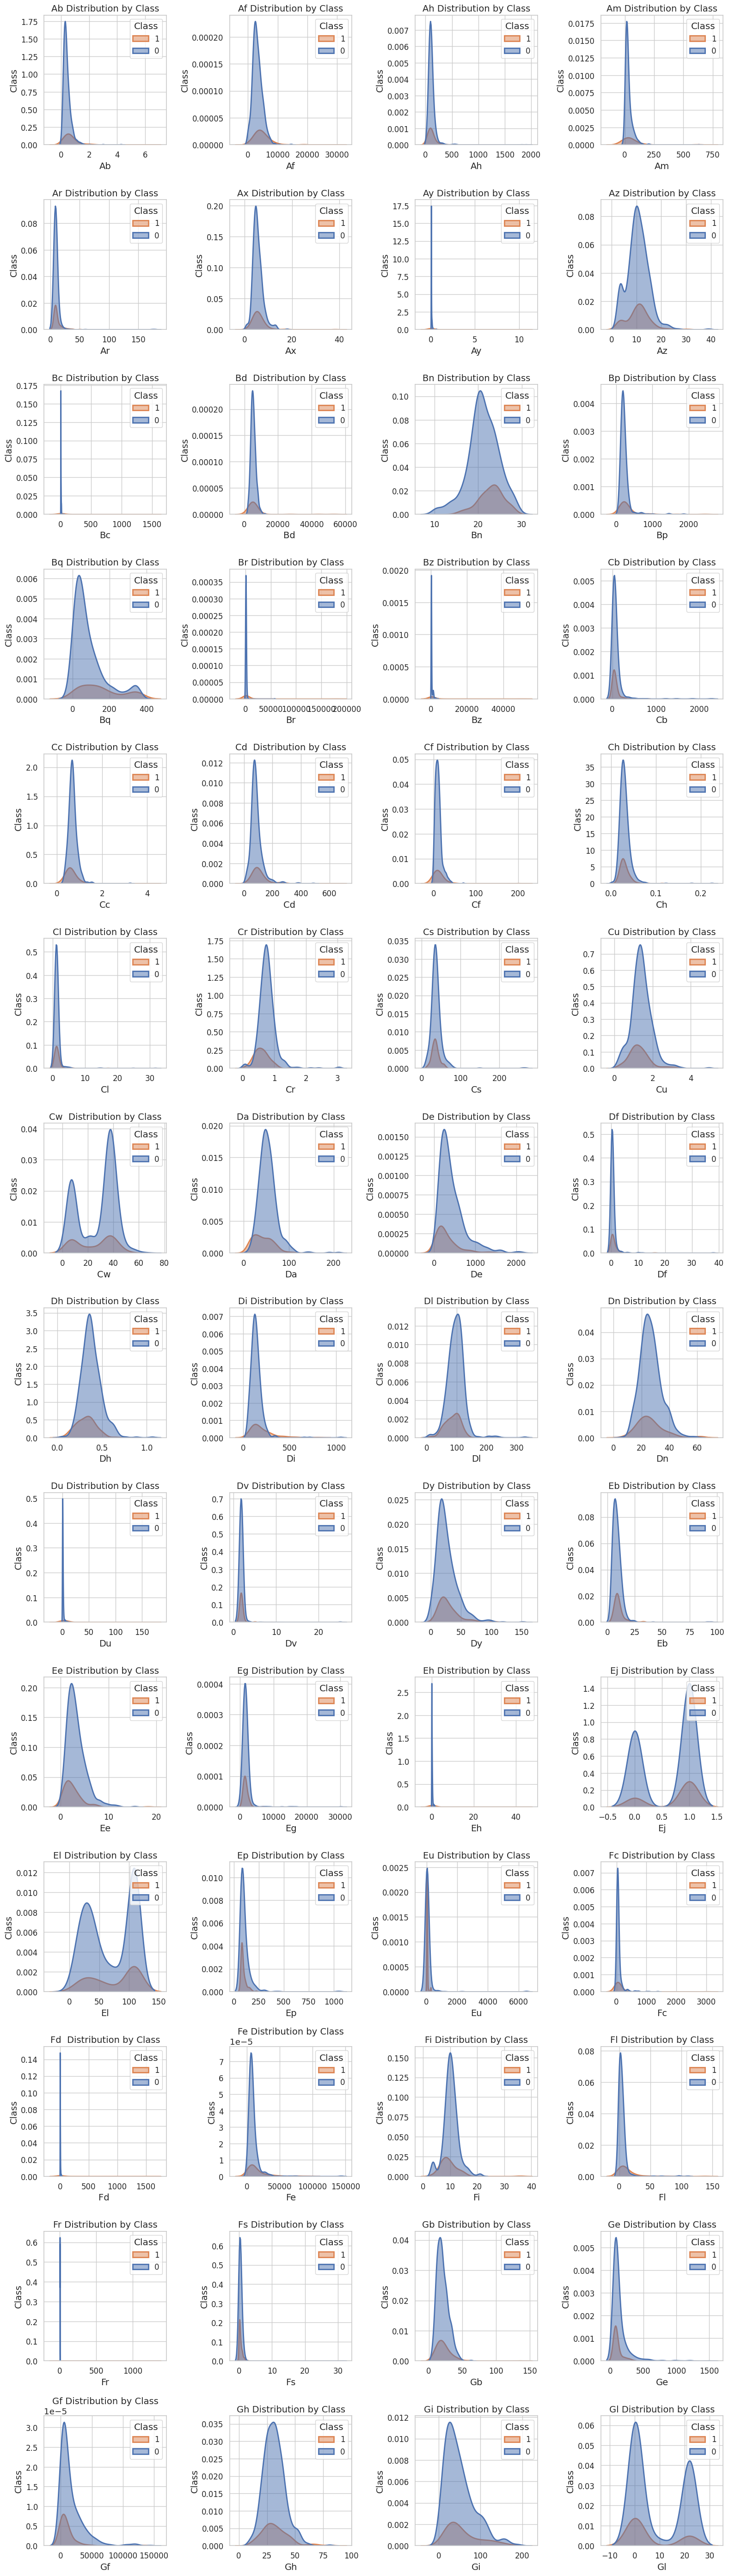

In [ ]:
# 각 변수의 데이터 분포 확인 : 커널 밀도 추정 그래프 그리기

def plot_distribution(data):
    num_cols = 4
    num_rows = len(df_train.columns) // num_cols
    fig, axes = plt.subplots(nrows = num_rows, ncols = num_cols, figsize = (16, 4 * num_rows))
    sns.set(font_scale = 1.2, style = 'whitegrid')

    for i, col_name in enumerate(df_train.columns):
        if col_name != 'Class':
            ax = axes[i // num_cols, i % num_cols]
            sns.kdeplot(data = data, x = col_name, hue = target_col, ax = ax, fill = True, alpha = 0.5, linewidth = 2)
            ax.set_title(f'{col_name.title()} Distribution by {target_col.title()}', fontsize = 14) # 타이틀
            ax.set_xlabel(col_name.title(), fontsize = 14) # xlabel 설정
            ax.set_ylabel(target_col.title(), fontsize = 14) # ylabel 설정
            ax.tick_params(axis = 'both', which = 'major', labelsize = 12) # 축 설정
            ax.legend([1,0], title = target_col.title(), fontsize = 12)

    plt.tight_layout()
    plt.show()

plot_distribution(data)

## kdeplot을 볼 때 의학적 상태 이상을 가지지 않은(클래스0) 케이스와 그렇지 않은 경우(클래스1)의 분포는 유사하게 나타나고 있다.

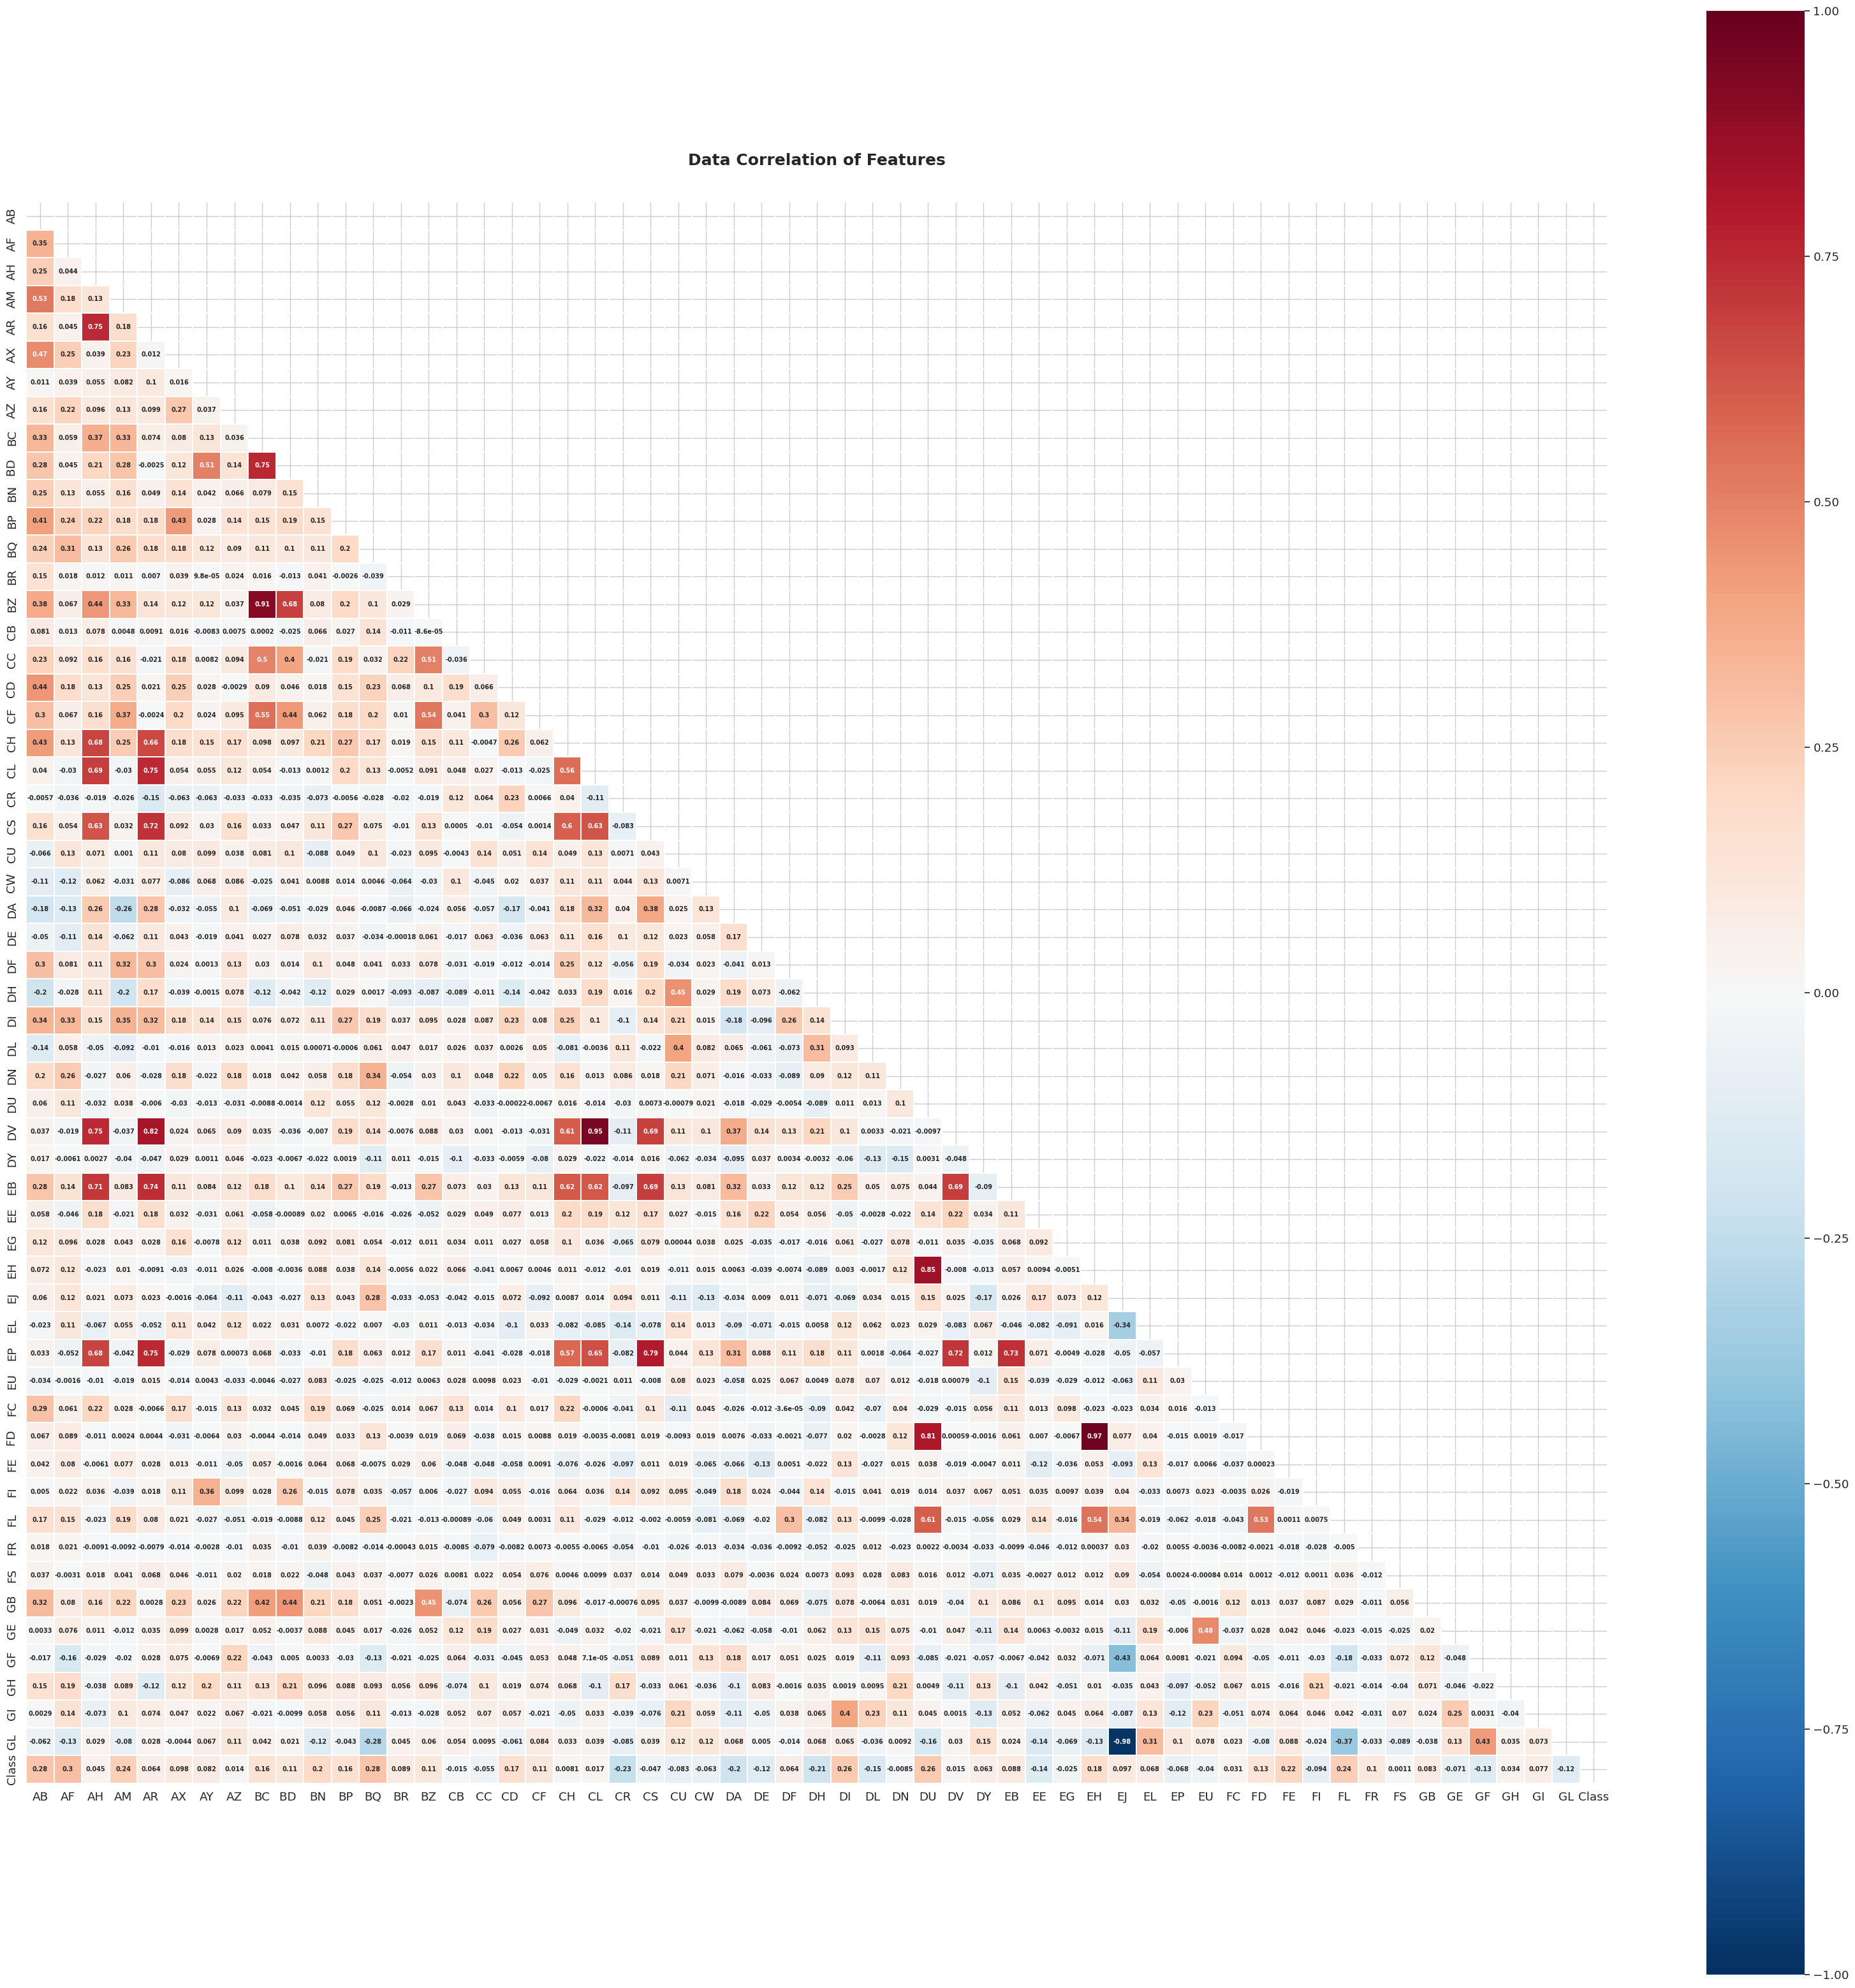

In [ ]:
# 변수 상관관계 확인을 위한 히트맵 그리기

def plot_heatmap(df, title):
    # 대각선 상의 원소를 생성
    mask = np.zeros_like(df.astype(float).corr())
    mask[np.triu_indices_from(mask)] = True

    # 맵 색상과 사이즈 설정
    colormap = plt.cm.RdBu_r
    plt.figure(figsize = (40,40))

    # 제목과 글꼴 속성 설정
    plt.title(f'{title} Correlation of Features', fontweight = 'bold', y = 1.02, size = 18)

    # 마스크된 대각선 원소를 그리기
    sns.heatmap(df.astype(float).corr(), linewidths = 0.1, vmax = 1.0, vmin = -1.0,
                square = True, cmap = colormap, linecolor = 'white', annot = True, annot_kws = {"size" : 7, "weight" : "bold"}, mask = mask)

plot_heatmap(df_train, title = 'Data')

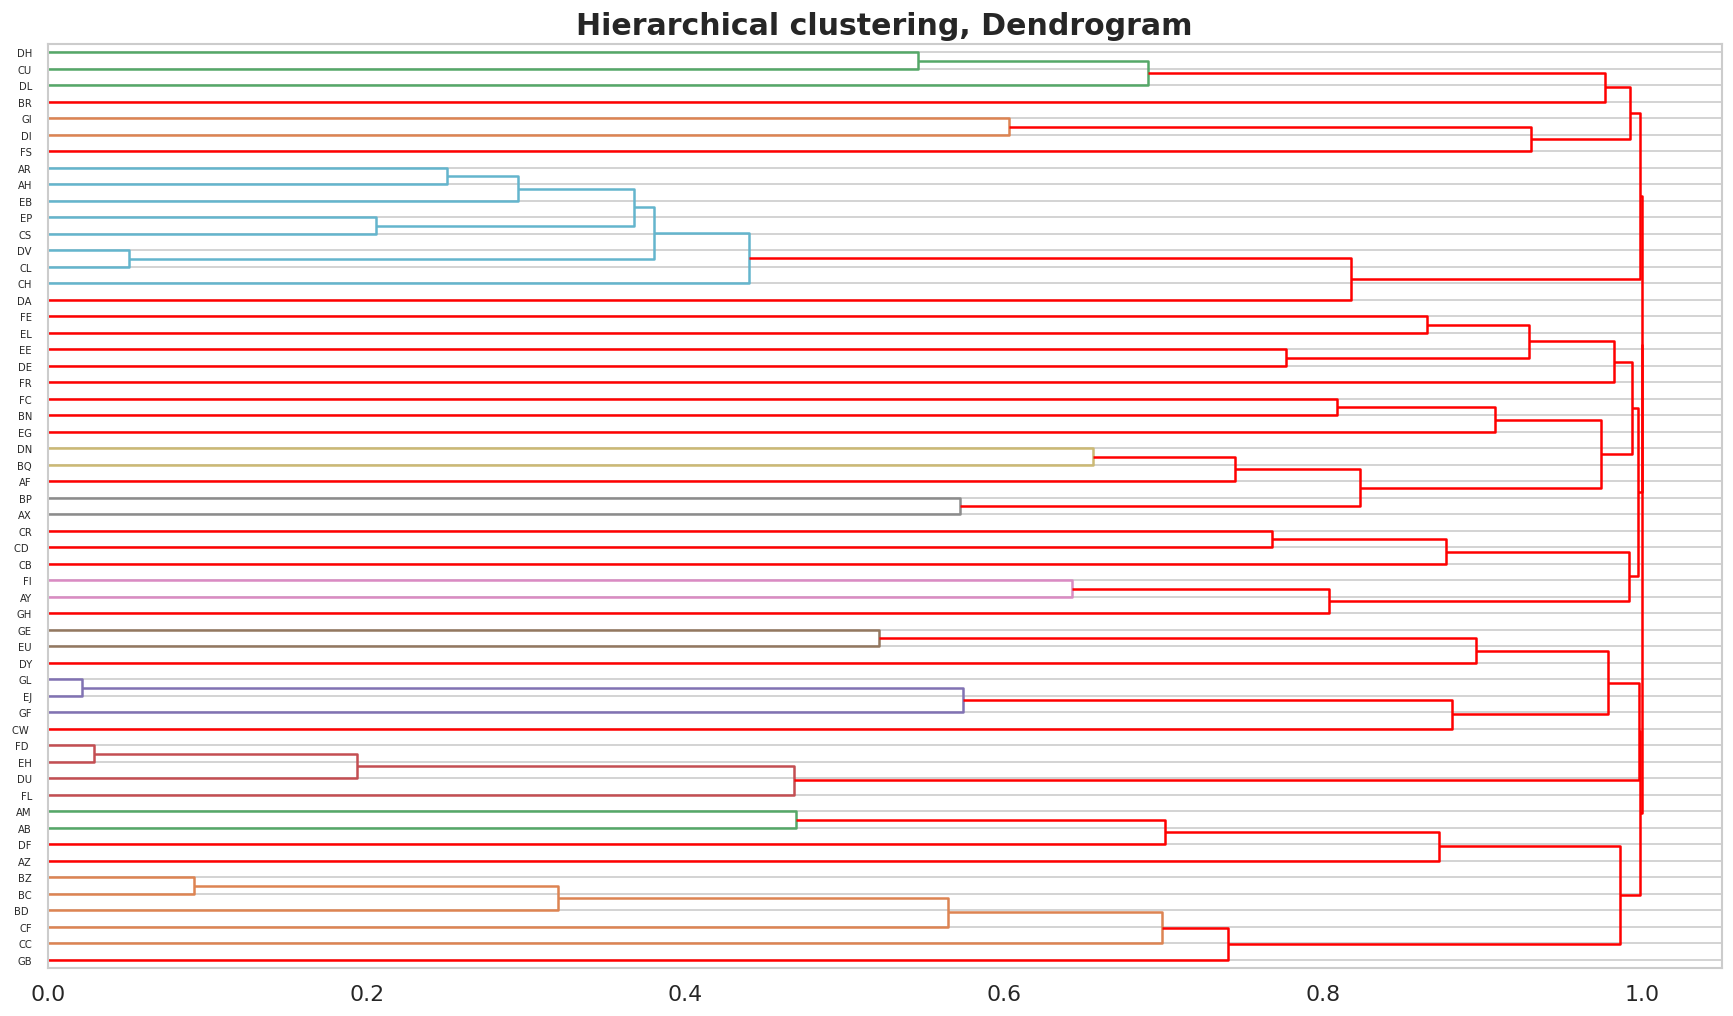

In [ ]:
# 계층적 군집화 덴드로그램 시각화

from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

def hierarchical_clustering(data):
    fig, ax = plt.subplots(1, 1, figsize = (18, 10), dpi = 120)
    correlation = data.corr()
    converted_corr = 1 - np.abs(correlation)
    Z = linkage(squareform(converted_corr), 'complete')

    dn = dendrogram(Z, labels = data.columns, ax = ax, above_threshold_color = '#ff0000',
                    orientation = 'right')
    hierarchy.set_link_color_palette(None)
    plt.grid(axis = 'x')
    plt.title('Hierarchical clustering, Dendrogram', fontsize=18, fontweight='bold')
    plt.show()

hierarchical_clustering(df_train.drop(target_col, axis = 1))

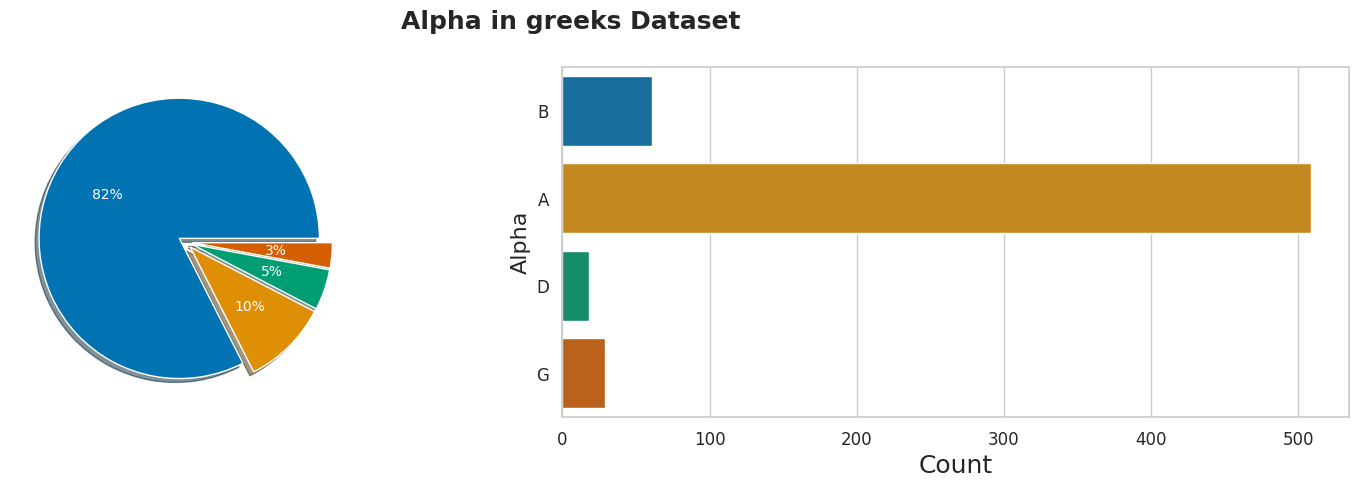

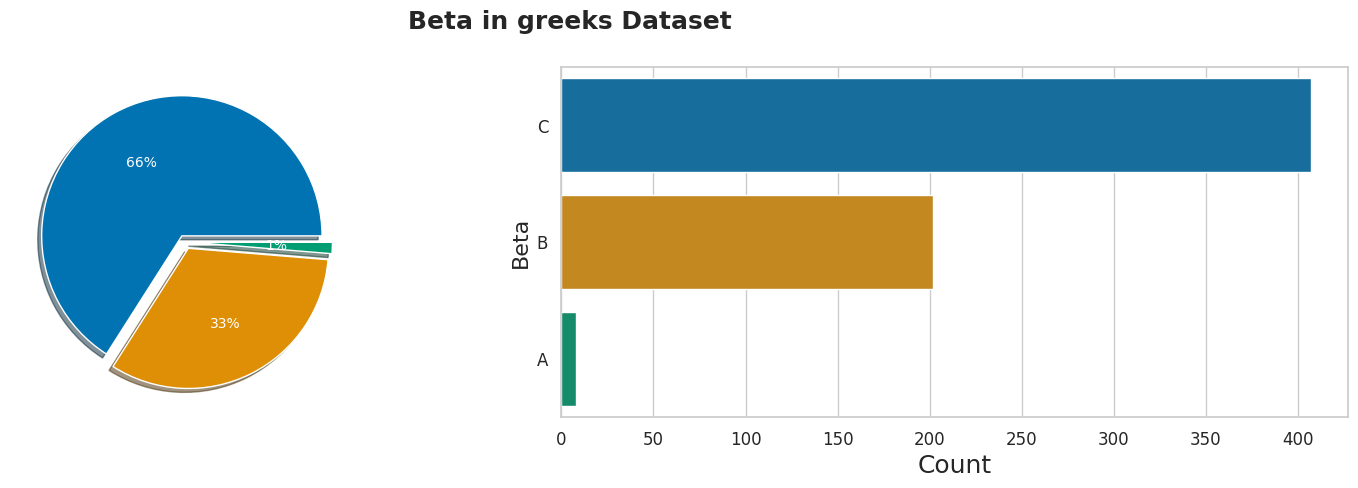

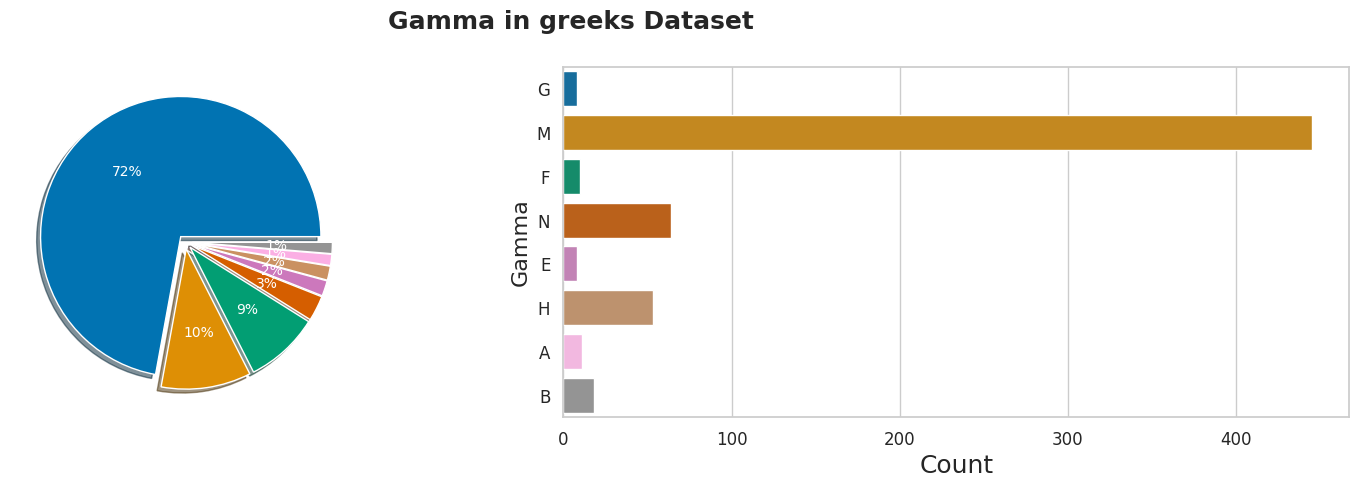

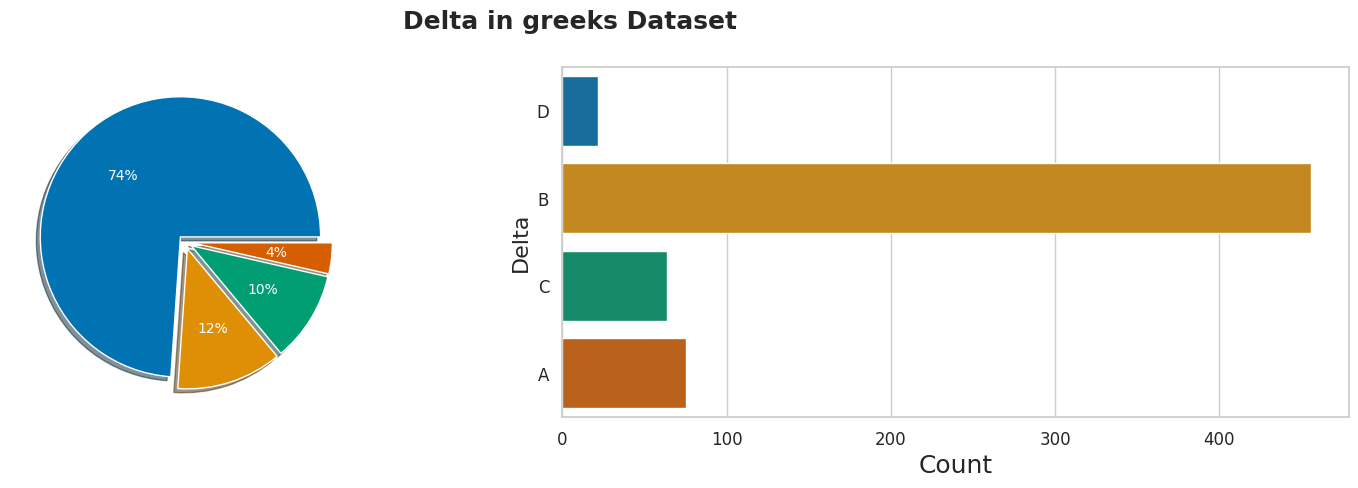

In [ ]:
#

def plot_target_feature(df_train, target_col, figsize = (16,5), palette = 'colorblind', name = 'Train'):
    dr_train = df_train.fillna('Nan')

    fig, ax = plt.subplots(1, 2, figsize = figsize)
    ax = ax.flatten()

    # 파이 차트
    ax[0].pie(
        df_train[target_col].value_counts(),
        shadow = True,
        explode = [0.05] * len(df_train[target_col].unique()),
        autopct = '%1.f%%',
        textprops = {'size' : 10, 'color' : 'white'},
        colors = sns.color_palette(palette, len(df_train[target_col].unique()))
    )

    # 막대 차트
    sns.countplot(
        data = df_train,
        y = target_col,
        ax = ax[1],
        palette = palette
    )
    ax[1].yaxis.label.set_size(16)
    plt.yticks(fontsize = 12)
    ax[1].set_xlabel('Count', fontsize = 18)
    plt.xticks(fontsize = 12)

    fig.suptitle(f'{target_col} in {name} Dataset', fontsize = 18, fontweight = 'bold')
    plt.tight_layout()

    plt.show()

plot_target_feature(data, 'Alpha', figsize=(16,5), palette='colorblind', name='greeks')
plot_target_feature(data, 'Beta', figsize=(16,5), palette='colorblind', name='greeks')
plot_target_feature(data, 'Gamma', figsize=(16,5), palette='colorblind', name='greeks')
plot_target_feature(data, 'Delta', figsize=(16,5), palette='colorblind', name='greeks')

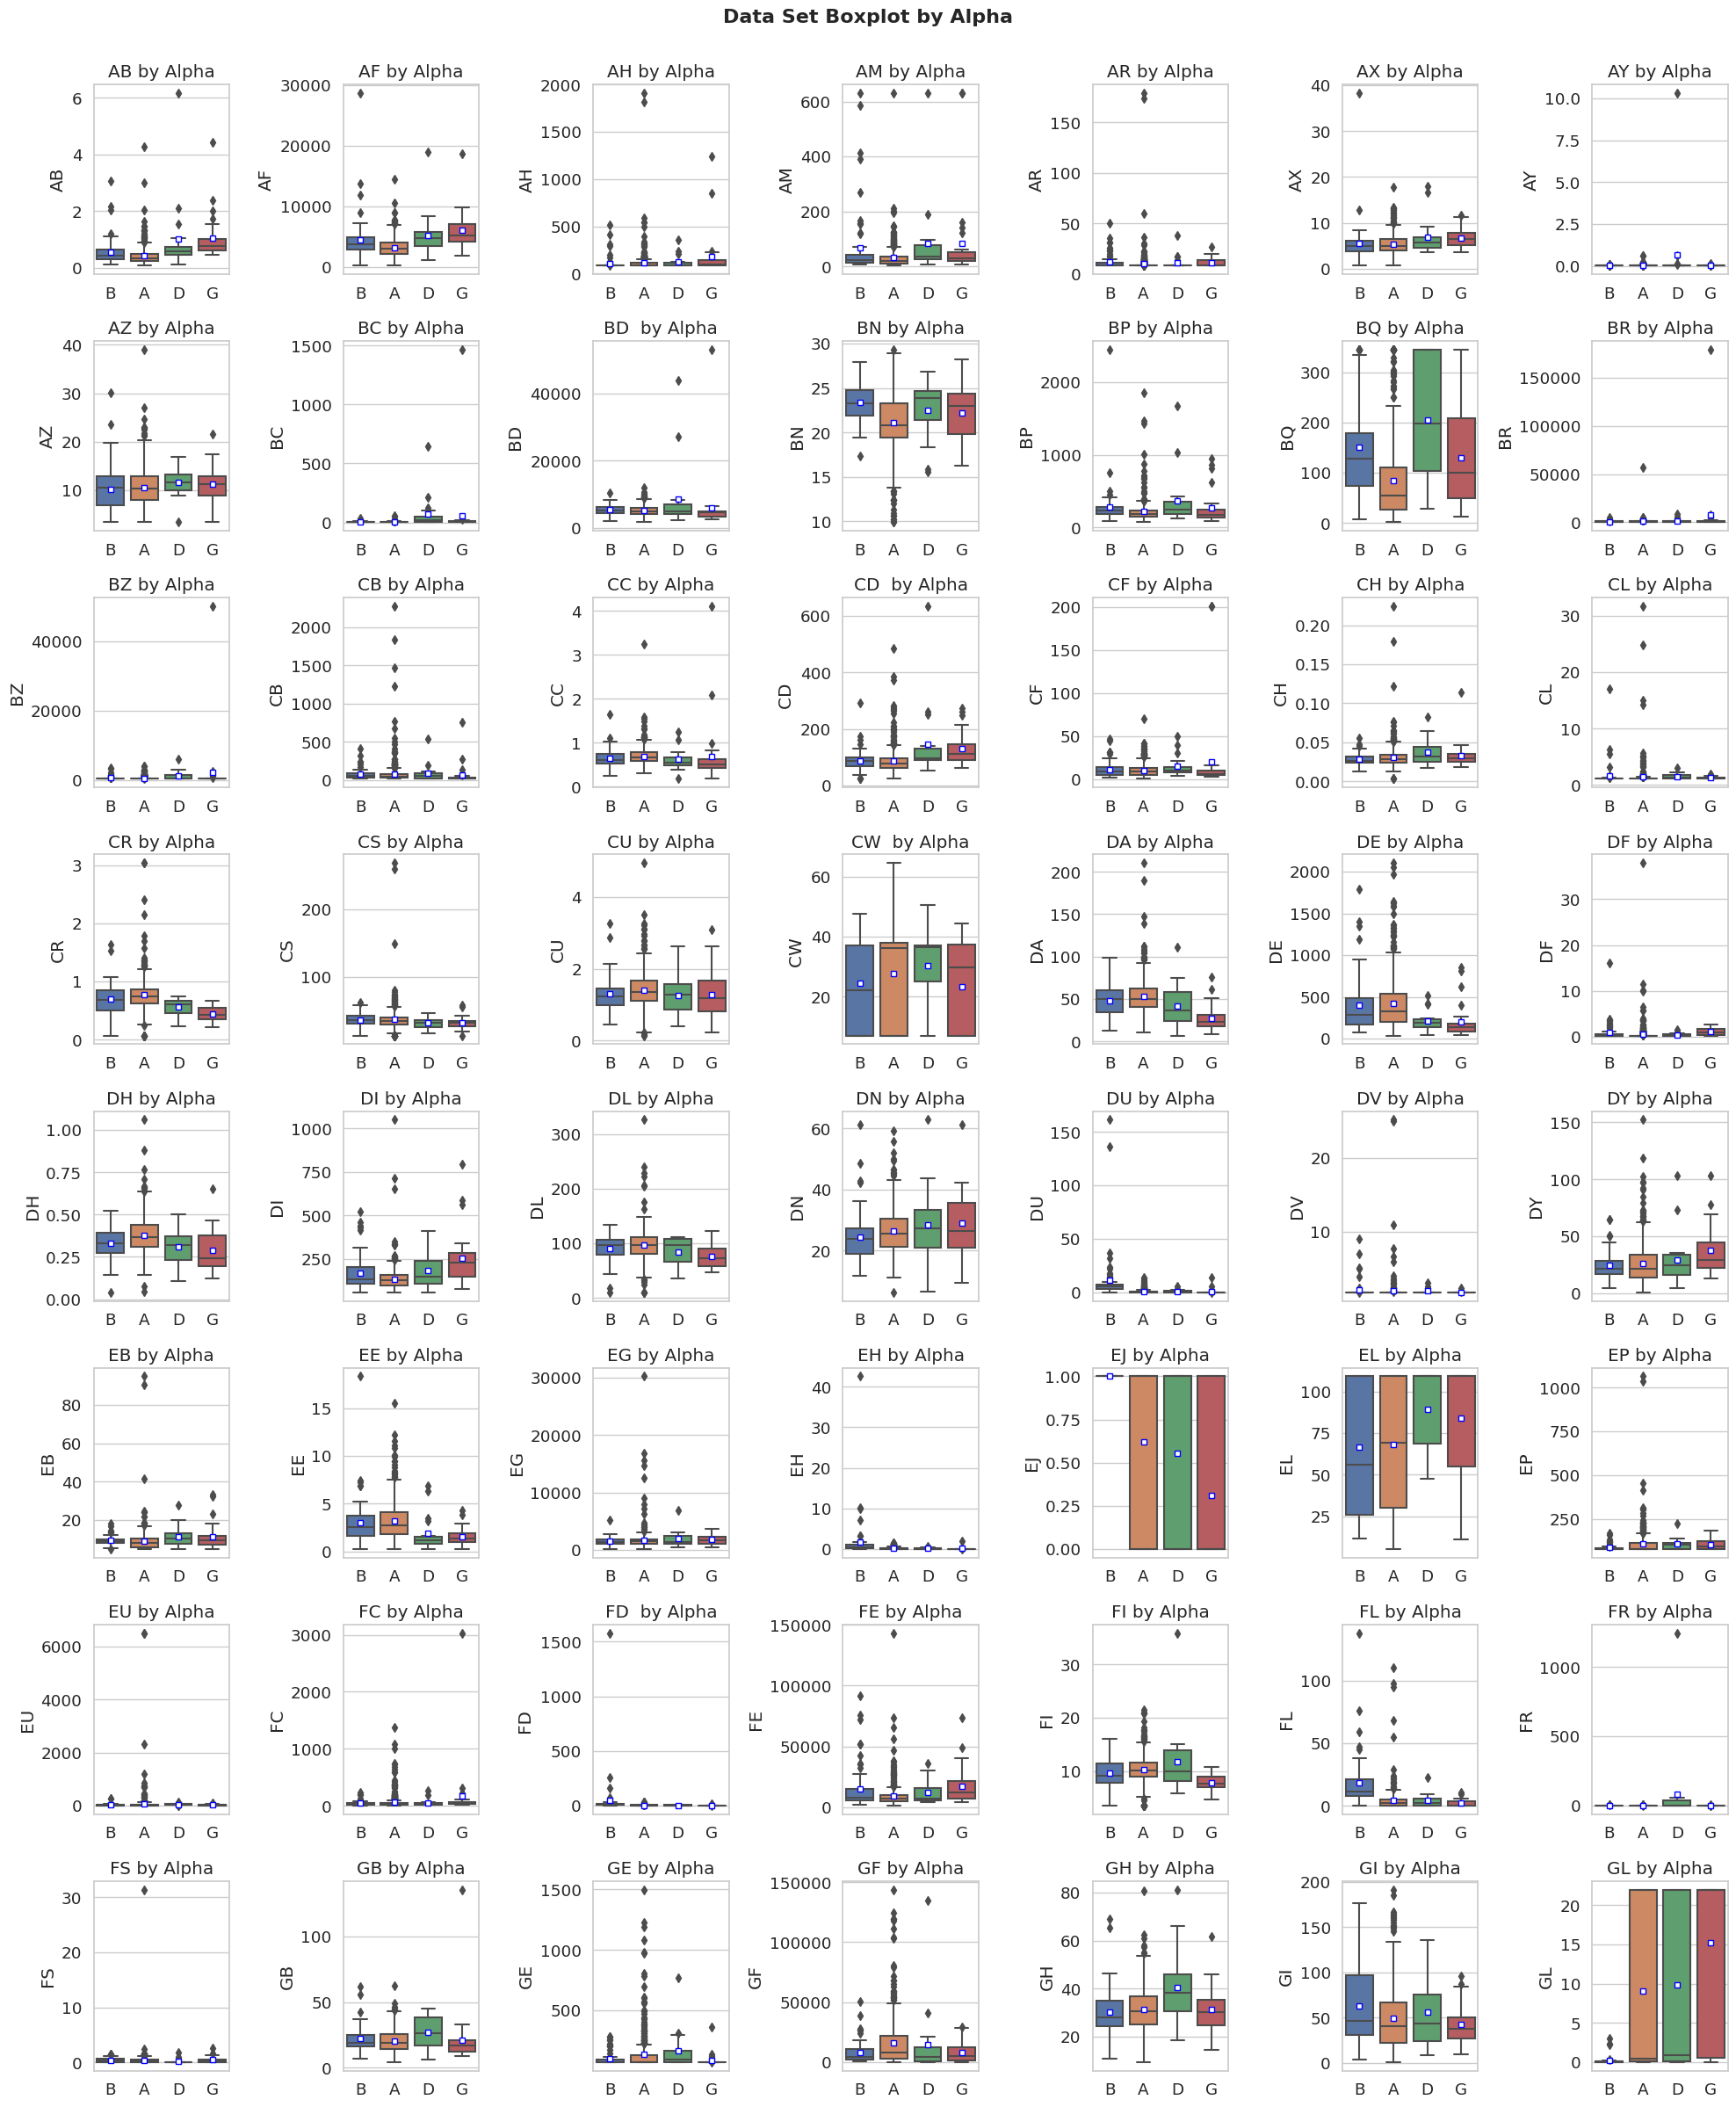

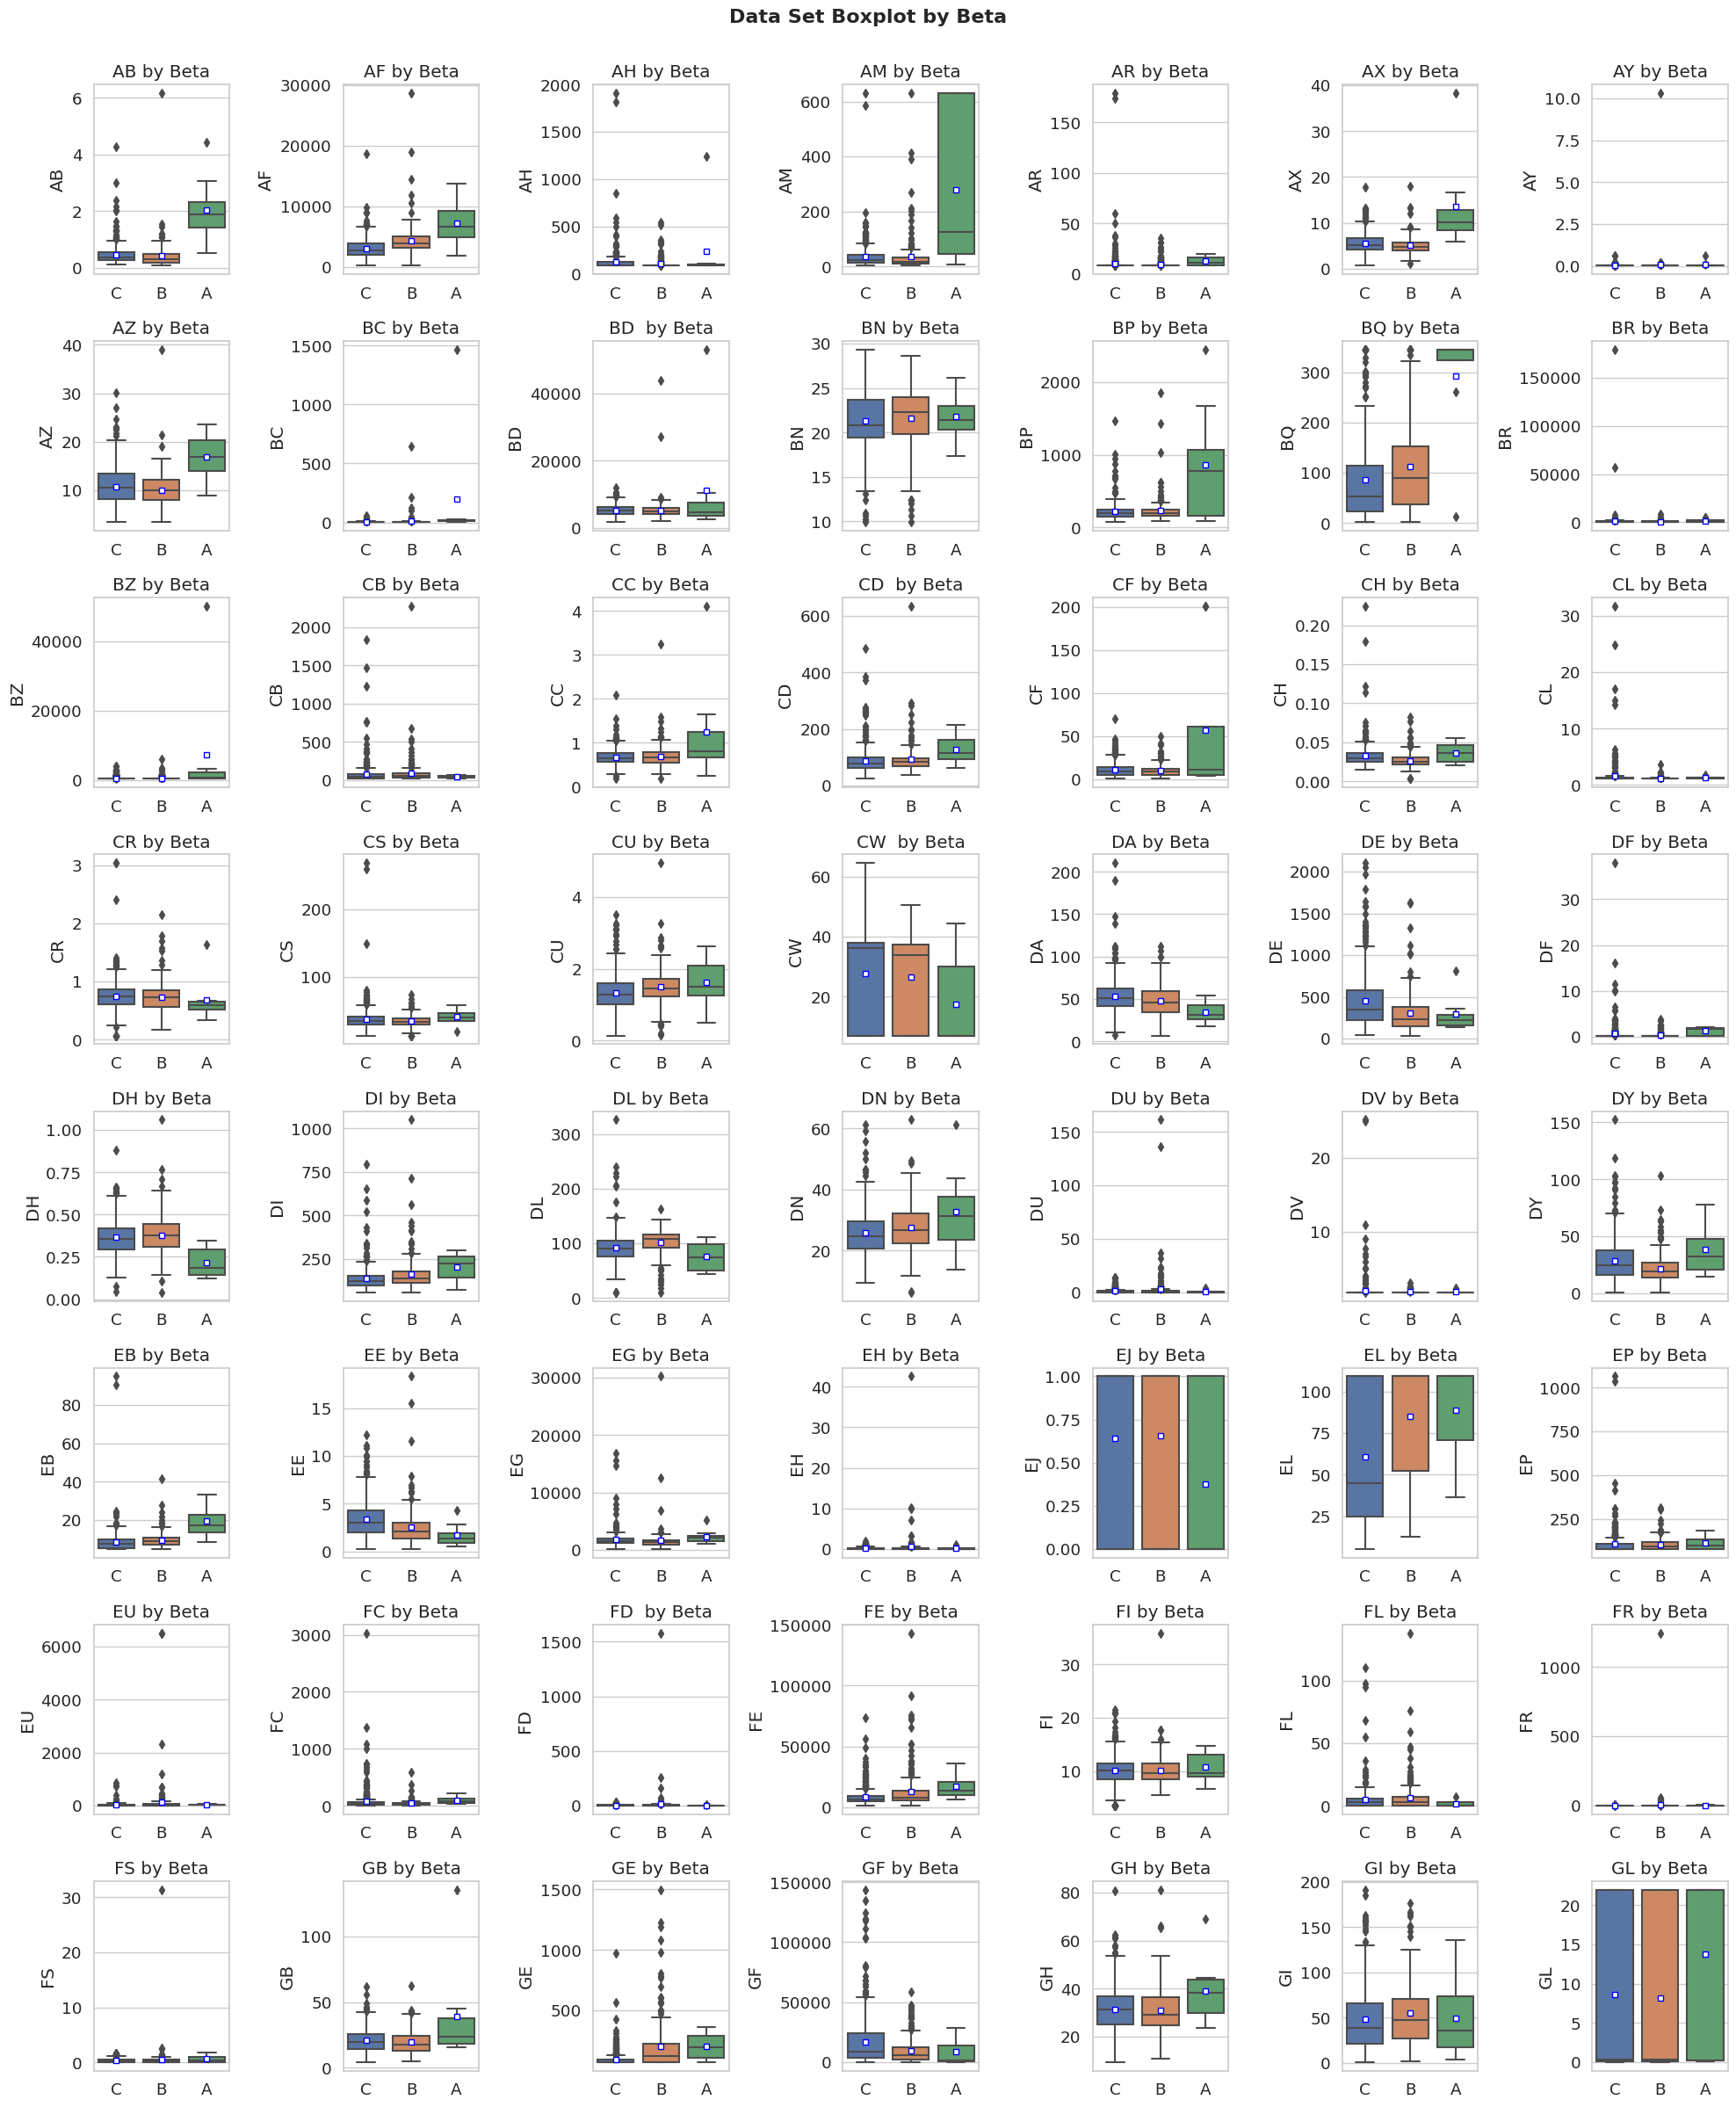

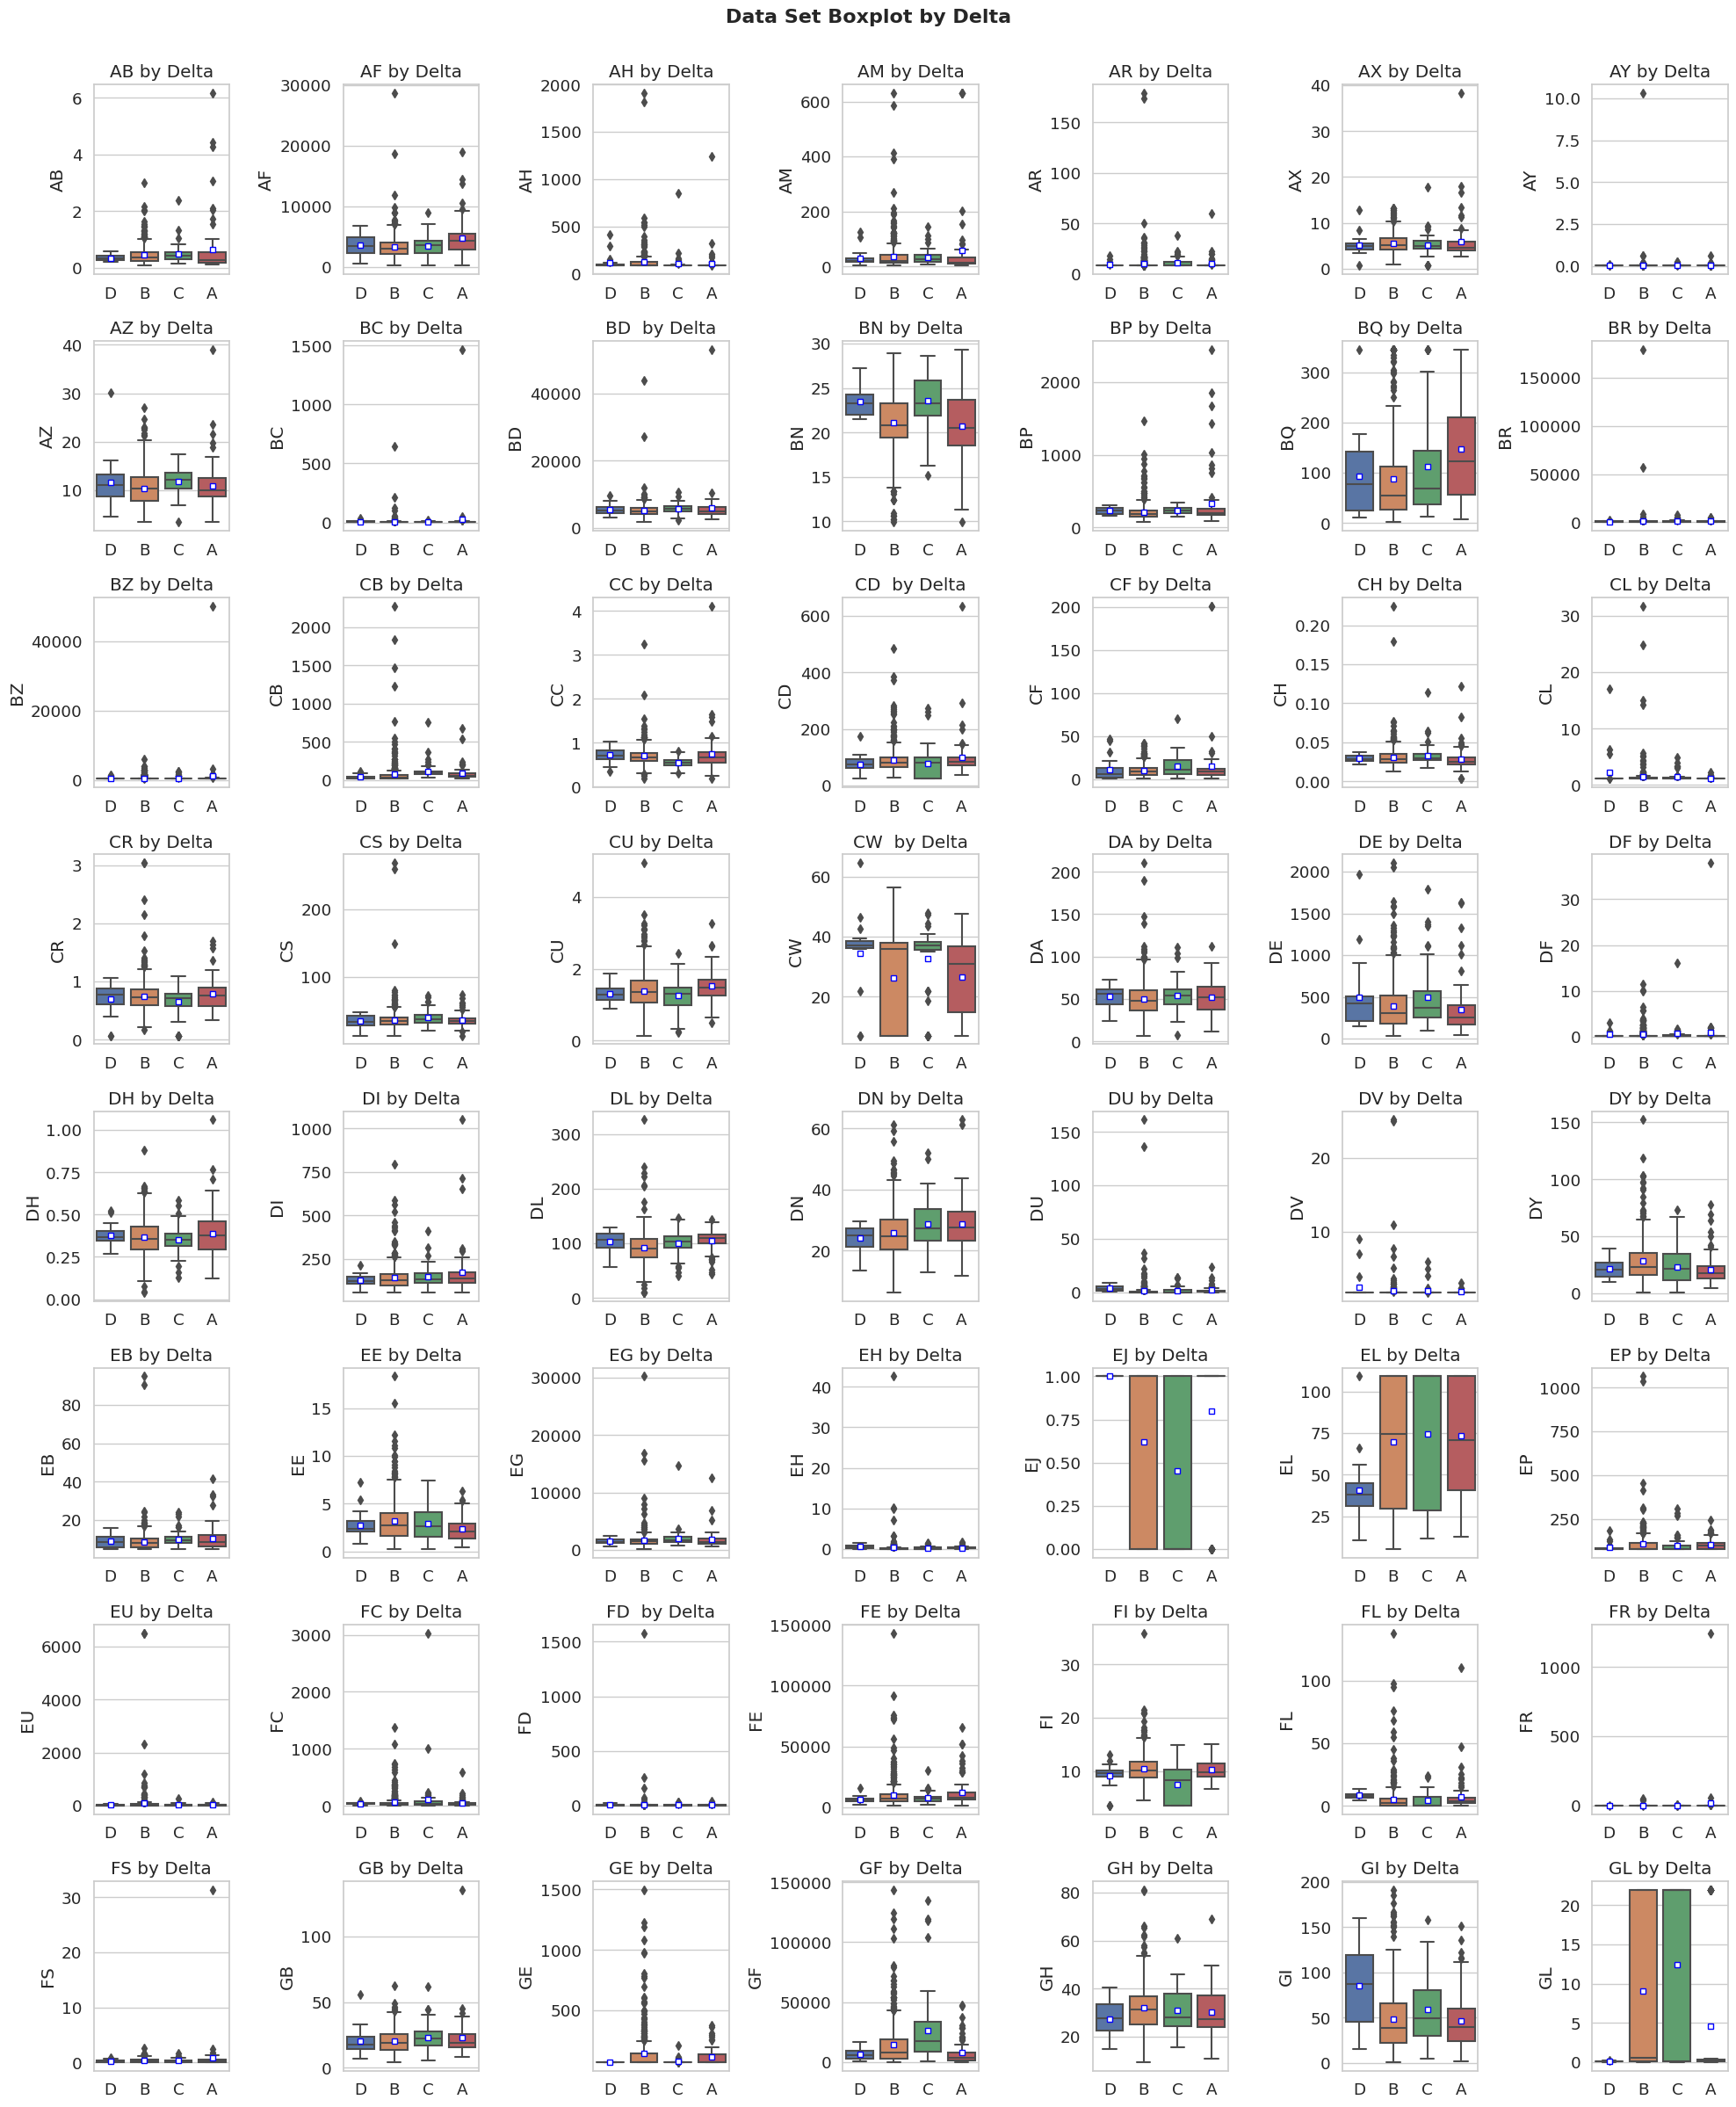

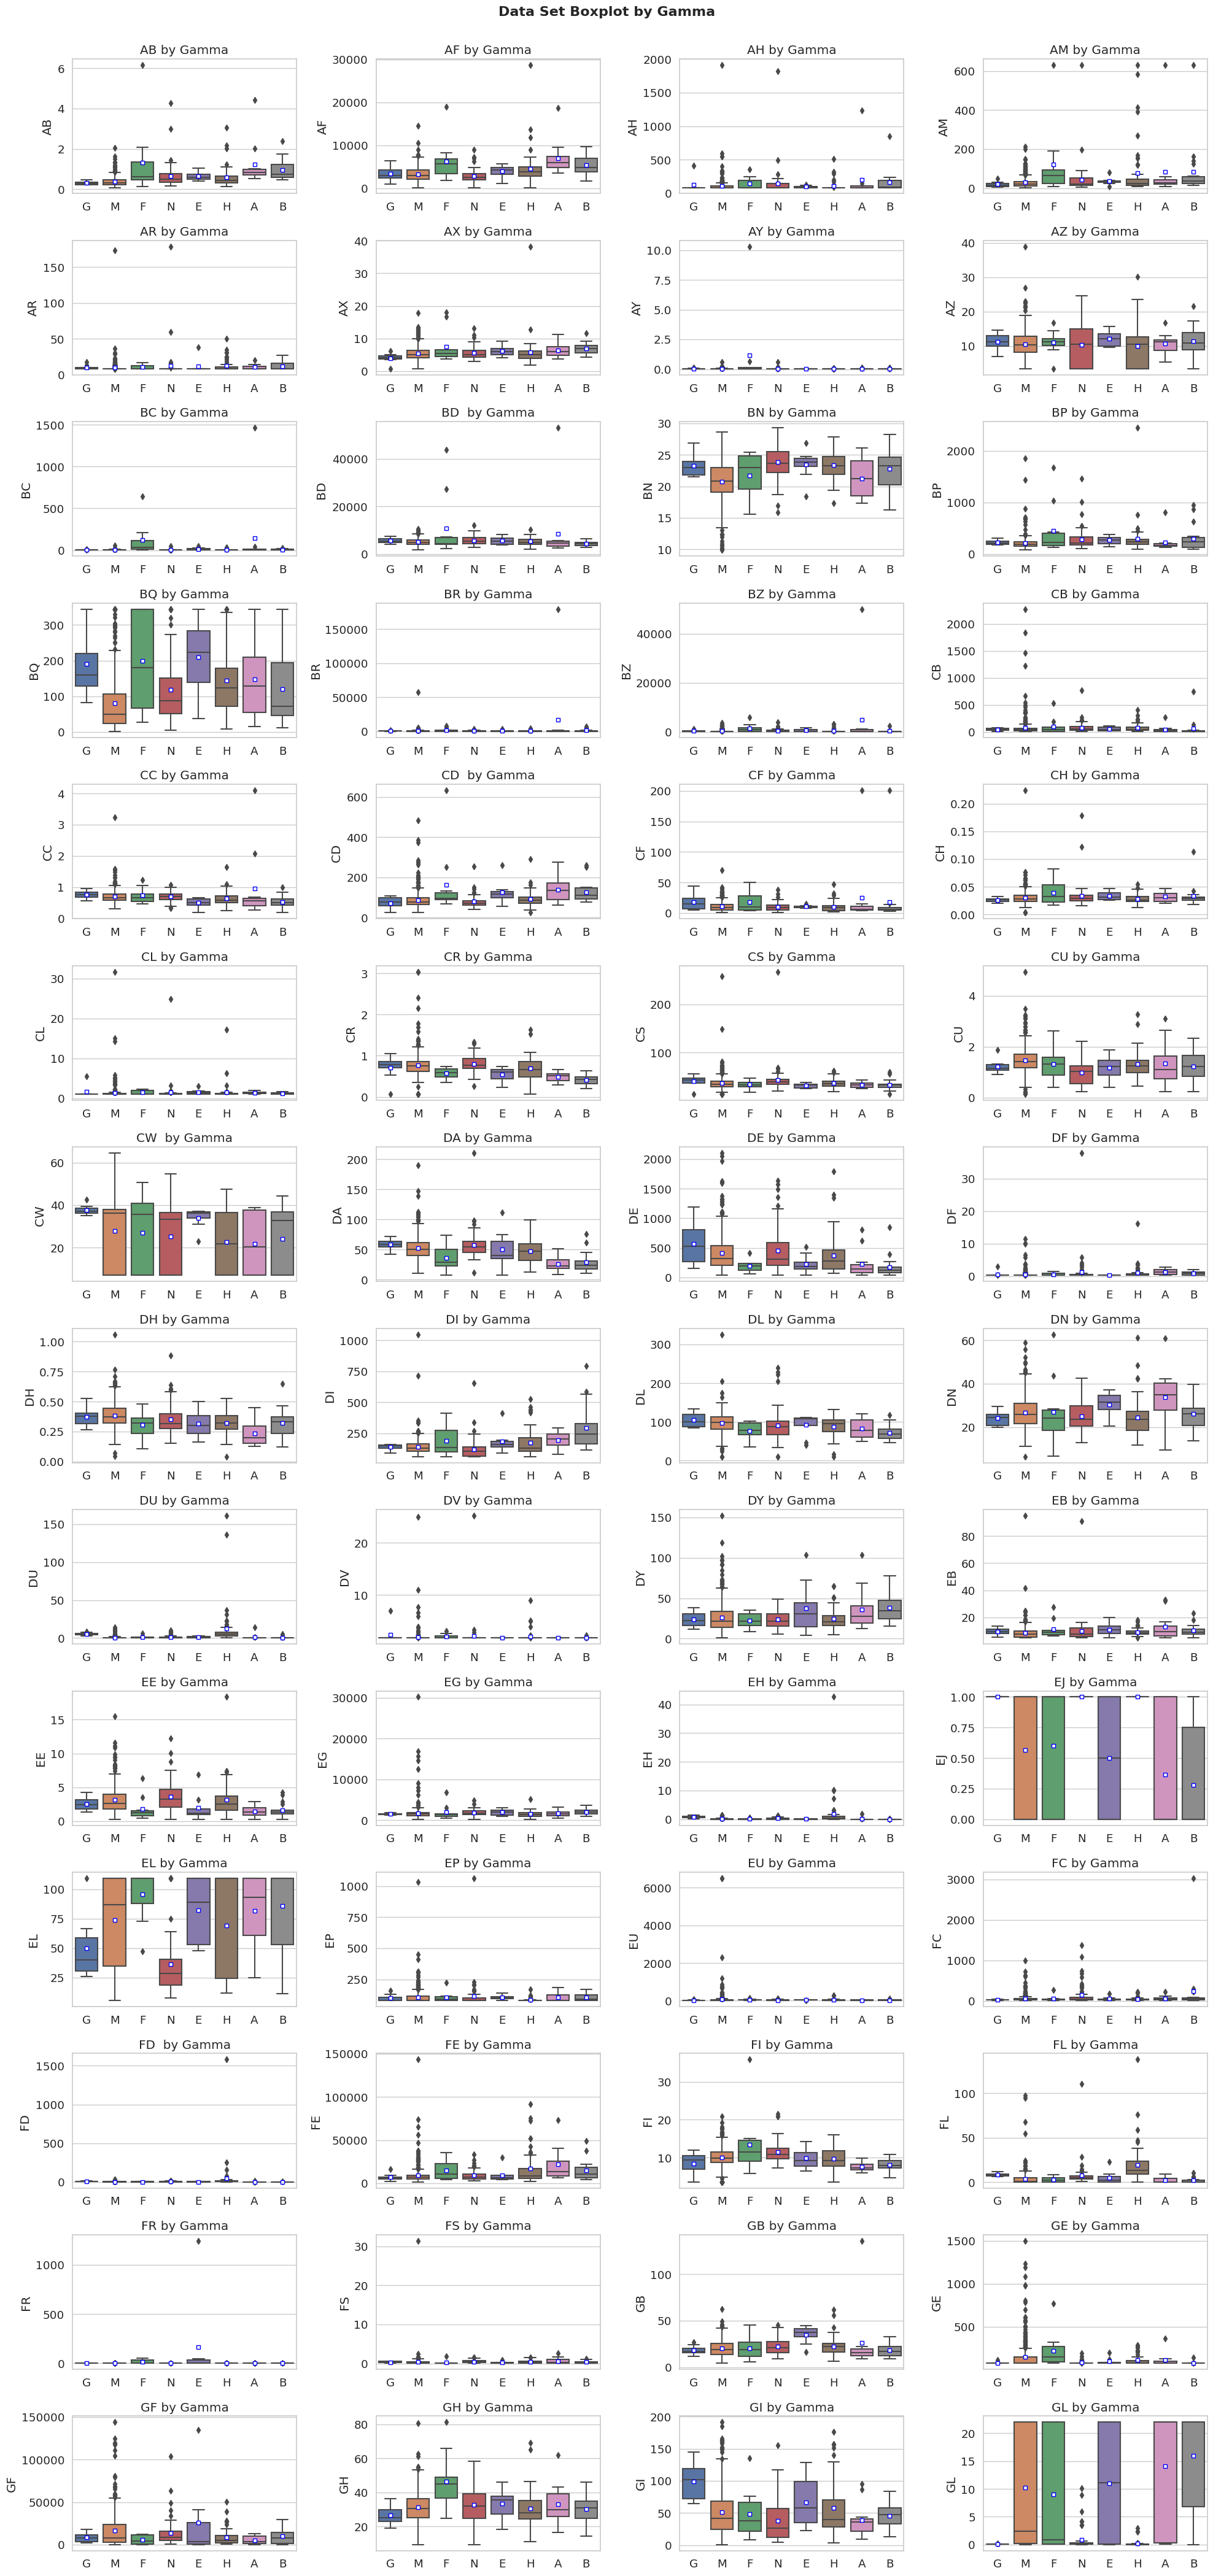

In [ ]:
# 박스차트

def plot_boxplot(df, hue, title = '', drop_cols = [], n_cols = 3):
    sns.set_style('whitegrid')

    cols = df.columns.drop([hue] + drop_cols)
    n_rows = (len(cols) - 1) // n_cols + 1

    fig, axes = plt.subplots(nrows = n_rows, ncols = n_cols, figsize = (20, 3 * n_rows))

    for i, var_name in enumerate(cols):
        row = i // n_cols
        col = i % n_cols

        ax = axes[row, col]
        sns.boxplot(data = df, x = hue, y = var_name, ax = ax, showmeans = True,
                    meanprops = {"marker" : "s", "markerfacecolor" : "white", "markeredgecolor" : "blue",
                                 "markersize" : 5})
        ax.set_title(f'{var_name} by {hue}')
        ax.set_xlabel('')

    fig.suptitle(f'{title} Boxplot by {hue}', fontweight = 'bold', fontsize = 16, y = 1.00)
    plt.tight_layout()
    plt.show()

plot_boxplot(data, hue='Alpha', title='Data Set', drop_cols=['Beta', 'Gamma', 'Delta', 'Epsilon', target_col], n_cols=7)
plot_boxplot(data, hue='Beta', title='Data Set', drop_cols=['Alpha', 'Gamma', 'Delta', 'Epsilon', target_col], n_cols=7)
plot_boxplot(data, hue='Delta', title='Data Set', drop_cols=['Alpha', 'Beta', 'Gamma', 'Epsilon', target_col], n_cols=7)
plot_boxplot(data, hue='Gamma', title='Data Set', drop_cols=['Alpha', 'Beta', 'Delta', 'Epsilon', target_col], n_cols=4)

## 학습, 테스트 데이터 준비

In [14]:
df_train = pd.read_csv('/content/train.csv', index_col = [0]) # 첫 번째 col을 index로 사용한다.
df_test = pd.read_csv('/content/test.csv', index_col = [0])
greeks = pd.read_csv('/content/greeks.csv')
df_train['EJ'] = df_train['EJ'].replace({'A' : 0, 'B' : 1})
df_test['EJ'] = df_test['EJ'].replace({'A' : 0, 'B' : 1})
target_col = 'Class'

X_train = df_train.drop([f'{target_col}'], axis = 1).reset_index(drop = True)
y_train = df_train[f'{target_col}'].reset_index(drop = True)
X_test = df_test.reset_index(drop = True)

drop_cols = ['BC', 'CL']
X_train.drop(drop_cols, axis = 1, inplace = True)
X_test.drop(drop_cols, axis = 1, inplace = True)

numeric_columns = [_ for _ in X_train.columns if _ not in ['EJ']]
sc = StandardScaler()
X_train[numeric_columns] = sc.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = sc.transform(X_test[numeric_columns])

print(f"X_train shape {X_train.shape}, y_train_shape : {y_train.shape}")
print(f"X_test shape : {X_test.shape}")

# df_train, df_test 삭제
del df_train, df_test

X_train.head()

X_train shape (617, 54), y_train_shape : (617,)
X_test shape : (5, 54)


AB        AF        AH        AM        AR        AX        AY  \
0 -0.572153 -0.170975 -0.261669 -0.237889 -0.189295 -1.900558 -0.083417   
1 -0.709105 -1.097801 -0.261669 -0.028701 -0.189295 -0.750457 -0.083417   
2 -0.015212 -0.377169 -0.261669 -0.094845 -0.189295  0.465662 -0.083417   
3 -0.480851  0.138196  0.012347  0.547477 -0.189295 -0.729610 -0.083417   
4 -0.206946  0.100517 -0.261669 -0.356885 -0.189295 -0.628845 -0.013229   

         AZ       BD         BN  ...        FI        FL        FR        FS  \
0 -0.173502 -0.405383  0.339209  ... -2.226608  0.162355 -0.035806 -0.250462   
1  0.678919  0.048541 -0.575174  ...  0.084542 -0.457909 -0.060566  0.113034   
2  0.519453 -0.071089  1.456789  ...  0.517060  0.198170 -0.051023  0.595966   
3  0.112088 -0.391109  0.644004  ...  1.617160  0.059978 -0.060566 -0.105064   
4 -1.649292  0.125327  0.745602  ...  1.212850  0.236779  0.896815 -0.229691   

         GB        GE        GF        GH        GI        GL  
0 -0.940094 -0.410260 -0.655511 -0.948991  0.531241 -0.815091  
1 -1.145070 -0.410260  0.687893 -0.238862 -0.509218  1.303181  
2  1.637944 -0.299210 -0.051850 -0.351743 -0.424754 -0.807668  
3 -0.219883 -0.342195 -0.650833  0.858232  1.101332 -0.811652  
4 -0.432313  0.099920 -0.318309  1.409422 -0.395228 -0.817391  

[5 rows x 54 columns]

## 모델 정의하기

In [22]:
class Splitter:
    def __init__(self, kfold = True, n_splits = 5, greeks = pd.DataFrame()):
        self.n_splits = n_splits
        self.kfold = kfold
        self.greeks = greeks

    def split_data(self, X, y, random_state_list):
        if self.kfold == 'skf':
            for random_state in random_state_list:
                kf = StratifiedKFold(n_splits=self.n_splits, random_state=random_state, shuffle=True)
                for train_index, val_index in kf.split(X, y):
                    if type(X) is np.ndarray:
                        X_train, X_val = X[train_index], X[val_index]
                        y_train, y_val = y[train_index], y[val_index]
                    else:
                        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
                    yield X_train, X_val, y_train, y_val
        else:
            raise ValueError(f"Invalid kfold: Must be True")

class Classifier:
    def __init__(self, n_estimators = 100, device = 'cpu', random_state = 0):
        self.n_estimators = n_estimators
        self.device = device
        self.random_state = random_state
        self.models = self._define_model()
        self.models_name = list(self._define_model().keys())
        self.len_models = len(self.models)

    def _define_model(self):

        xgb_params = {
            'n_estimators': self.n_estimators,
            'learning_rate': 0.413327571405248,
            'booster': 'gbtree',
            'lambda': 0.0000263894617720096,
            'alpha': 0.000463768723479341,
            'subsample': 0.237467672874133,
            'colsample_bytree': 0.618829300507829,
            'max_depth': 5,
            'min_child_weight': 9,
            'eta': 2.09477807126539E-06,
            'gamma': 0.000847289463422307,
            'grow_policy': 'depthwise',
            'n_jobs': -1,
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'verbosity': 0,
            'random_state': self.random_state,
        }
        if self.device == 'gpu':
            xgb_params['tree_method'] = 'gpu_hist'
            xgb_params['predictor'] = 'gpu_predictor'

        lgb_params = {
            'n_estimators': self.n_estimators,
            'objective': 'binary',
            'boosting_type': 'gbdt',
            'learning_rate': 0.005,
            'num_leaves': 5,
            'colsample_bytree': 0.50,
            'subsample': 0.80,
            'reg_alpha': 2,
            'reg_lambda': 4,
            'n_jobs': -1,
            'is_unbalance':True,
            'device': self.device,
            'random_state': self.random_state
        }
        lgb1_params = {
            'n_estimators': self.n_estimators,
            'learning_rate': 0.190197487721534,
            'reg_alpha': 0.00749112221417973,
            'reg_lambda': 0.000548118227209224,
            'num_leaves': 17,
            'colsample_bytree': 0.547257860506146,
            'subsample': 0.592628085686409,
            'subsample_freq': 2,
            'min_child_samples': 64,
            'objective': 'binary',
            #'metric': 'binary_error',
            'boosting_type': 'gbdt',
            'is_unbalance':True,
            'device': self.device,
            'random_state': self.random_state
        }
        lgb2_params = {
            'n_estimators': self.n_estimators,
            'learning_rate': 0.181326407627473,
            'reg_alpha': 0.000030864084239014,
            'reg_lambda': 0.0000395714763869486,
            'num_leaves': 122,
            'colsample_bytree': 0.75076596295323,
            'subsample': 0.6303245788342,
            'subsample_freq': 3,
            'min_child_samples': 72,
            'objective': 'binary',
            #'metric': 'binary_error',
            'boosting_type': 'gbdt',
            'is_unbalance':True,
            'device': self.device,
            'random_state': self.random_state
        }
        cat_params = {
            'iterations': self.n_estimators,
            'colsample_bylevel': 0.0513276895988184,
            'depth': 2,
            'learning_rate': 0.0256579773375401,
            'l2_leaf_reg': 8.22319805476255,
            'random_strength': 0.11327724457066,
            'od_type': "Iter",
            'od_wait': 72,
            'bootstrap_type': "Bayesian",
            'grow_policy': 'SymmetricTree',
            'bagging_temperature': 9.58737431845122,
            #'eval_metric': 'Logloss',
            #'loss_function': 'Logloss',
            'auto_class_weights': 'Balanced',
            'task_type': self.device.upper(),
            'random_state': self.random_state
        }
        hist_params = {
            'l2_regularization': 0.01,
            'early_stopping': True,
            'learning_rate': 0.01,
            'max_iter': self.n_estimators,
            'max_depth': 4,
            'max_bins': 255,
            'min_samples_leaf': 10,
            'max_leaf_nodes':10,
            'class_weight':'balanced',
            'random_state': self.random_state
        }
        models = {
            'xgb': xgb.XGBClassifier(**xgb_params),
            'lgb': lgb.LGBMClassifier(**lgb_params),
            'lgb1': lgb.LGBMClassifier(**lgb1_params),
            'lgb2': lgb.LGBMClassifier(**lgb2_params),
            'hgb': HistGradientBoostingClassifier(**hist_params),
            'cat': CatBoostClassifier(**cat_params),
        }

        return models

## 평가지표

In [11]:
def calc_log_loss_weight(y_true):
    nc = np.bincount(y_true)
    w0, w1 = 1 / (nc[0] / y_true.shape[0]), 1 / (nc[1] / y_true.shape[0])
    return w0, w1

def balanced_log_loss(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
    nc = np.bincount(y_true)
    w0, w1 = 1/(nc[0]/y_true.shape[0]), 1/(nc[1]/y_true.shape[0])
    balanced_log_loss_score = (-w0 / nc[0] * (np.sum(np.where(y_true == 0, 1, 0) * np.log(1 - y_pred)))
    - w1 / nc[1] * (np.sum(np.where(y_true != 0, 1, 0) * np.log(y_pred)))) / (w0 + w1)
    return balanced_log_loss_score

## 옵티마이저

In [24]:
class OptunaWeights:
    def __init__(self, random_state, n_trials = 3000):
        self.study = None
        self.weights = None
        self.random_state = random_state
        self.n_trials = n_trials

    def _objective(self, trial, y_true, y_preds):
        # 각 모델에 대하여 가중치를 정의한다.
        weights = [trial.suggest_float(f"weight{n}", 1e-14, 1) for n in range(len(y_preds))]

        # 예상 가중치 계산
        weighted_pred = np.average(np.array(y_preds).T, axis = 1, weights = weights)

        # 가중 예측 점수 계산
        score = balanced_log_loss(y_true, weighted_pred)
        return score

    def fit(self, y_true, y_preds):
        optuna.logging.set_verbosity(optuna.logging.ERROR)
        sampler = optuna.samplers.CmaEsSampler(seed = self.random_state)
        pruner = optuna.pruners.HyperbandPruner()
        self.study = optuna.create_study(sampler = sampler, pruner=pruner, study_name="OptunaWeights", direction='minimize')
        objective_partial = partial(self. _objective, y_true = y_true, y_preds = y_preds)
        self.study.optimize(objective_partial, n_trials = self.n_trials)
        self.weights = [self.study.best_params[f"weight{n}"] for n in range(len(y_preds))]

    def predict(self, y_preds):
        assert self.weights is not None, 'OptunaWeights error, must be fitted before predict'

        weighted_pred = np.average(np.array(y_preds).T, axis = 1, weights = self.weights)
        return weighted_pred

    def fit_predict(self, y_true, y_preds):
        self.fit(y_true, y_preds)
        return self.predict(y_preds)

    def weights(self):
        return self.weights

## 기본 모델

In [25]:
%%time

kfold = 'skf'
n_splits = 5
n_reapts = 5
random_state = 71
n_estimators = 99999
early_stopping_rounds = 1000
verbose = False
device = 'cpu'

# seed 고정
random.seed(random_state)
random_state_list = random.sample(range(9999), n_reapts)

# 테스트 예측을 저장하기 위한 배열 초기화
classifier = Classifier(n_estimators, device, random_state)
test_predss = np.zeros((X_test.shape[0]))
oof_predss = np.zeros((X_train.shape[0], n_reapts))
ensemble_score, ensemble_score_ = [], []
weights = []
oof_each_predss = []
oof_each_preds = np.zeros((X_train.shape[0], classifier.len_models))
test_each_predss = []
test_each_preds = np.zeros((X_test.shape[0], classifier.len_models))
trained_models = {'xgb' : [], 'cat' : []}
score_dict = dict(zip(classifier.models_name, [[] for _ in range(classifier.len_models)]))

splitter = Splitter(kfold = kfold, n_splits = n_splits, greeks = greeks.iloc[:, 1:-1])
for i, (X_train_, X_val, y_train_, y_val) in enumerate(splitter.split_data(X_train, y_train,
                                                                           random_state_list = random_state_list)):
    n = i % n_splits
    m = i // n_splits

    # 분류 모델 세트 가져오기
    classifier = Classifier(n_estimators, device, random_state_list[m])
    models = classifier.models

    # oof를 저장하기 위한 목록을 초기화하고 각 기본 모델에 대한 예측을 테스트
    oof_preds = []
    test_preds = []

    # 각 기본 모델을 반복하고 훈련 데이터에 맞추고 검증 데이터를 평가하고 예측을 저장
    for name, model in models.items():
        if ('xgb' in name) or ('lgb' in name) or ('cat' in name):
            train_w0, train_w1 = calc_log_loss_weight(y_train_)
            valid_w0, valid_w1 = calc_log_loss_weight(y_val)

            if 'xgb' in name:
                model.fit(
                    X_train_, y_train_, sample_weight = y_train_.map({0 : train_w0, 1: train_w1}),
                    eval_set = [(X_val, y_val)], sample_weight_eval_set = [y_val.map({0 : valid_w0, 1 : valid_w1})],
                    early_stopping_rounds = early_stopping_rounds, verbose = verbose)

            elif 'lgb' in name:
                model.fit(
                    X_train_, y_train_, sample_weight=y_train_.map({0: train_w0, 1: train_w1}),
                    eval_set=[(X_val, y_val)], eval_sample_weight=[y_val.map({0: valid_w0, 1: valid_w1})],
                    early_stopping_rounds=early_stopping_rounds, verbose=verbose)

            elif 'cat' in name:
                model.fit(
                     Pool(X_train_, y_train_, weight=y_train_.map({0: train_w0, 1: train_w1})),
                    eval_set=Pool(X_val, y_val, weight=y_val.map({0: valid_w0, 1: valid_w1})),
                    early_stopping_rounds=early_stopping_rounds, verbose=verbose)
        else:
            model.fit(X_train_, y_train_)

        if name in trained_models.keys():
            trained_models[f'{name}'].append(deepcopy(model))

        test_pred = model.predict_proba(X_test)[:, 1].reshape(-1)
        y_val_pred = model.predict_proba(X_val)[:, 1].reshape(-1)

        score = balanced_log_loss(y_val, y_val_pred)
        score_dict[name].append(score)
        print(f'{name} [FOLD-{n} SEED-{random_state_list[m]}] BalancedLogLoss score : {score : .5f}')

        oof_preds.append(y_val_pred)
        test_preds.append(test_pred)

    # Optuna를 사용하여 최고의 앙상블 가중치 찾기
    optweights = OptunaWeights(random_state = random_state_list[m])
    y_val_pred = optweights.fit_predict(y_val.values, oof_preds)

    score = balanced_log_loss(y_val, y_val_pred)
    score_ = roc_auc_score(y_val, y_val_pred)
    print(f'--> Ensemble [FOLD-{n} SEED-{random_state_list[m]}] BalancedLogLoss score {score:.5f}')
    ensemble_score.append(score)
    ensemble_score_.append(score_)
    weights.append(optweights.weights)

    #최상의 앙상블 가중치로 X_test를 예측
    test_preds += optweights.predict(test_preds) / (n_splits * len(random_state_list))
    oof_predss[X_val.index, m] += optweights.predict(oof_preds)
    oof_each_preds[X_val.index] = np.stack(oof_preds).T
    test_each_preds += np.array(test_preds).T / n_splits
    if n == (n_splits - 1):
        oof_each_predss.append(oof_each_preds)
        oof_each_preds = np.zeros((X_train.shape[0], classifier.len_models))
        test_each_predss.append(test_each_preds)
        test_each_preds = np.zeros((X_test.shape[0], classifier.len_models))

    gc.collect()

oof_each_predss = np.mean(np.array(oof_each_predss), axis=0)
test_each_predss = np.mean(np.array(test_each_predss), axis=0)
oof_each_predss = np.concatenate([oof_each_predss, np.mean(oof_predss, axis=1).reshape(-1, 1)], axis=1)
test_each_predss = np.concatenate([test_each_predss, test_predss.reshape(-1, 1)], axis=1)

xgb [FOLD-0 SEED-5304] BalancedLogLoss score :  0.17309
lgb [FOLD-0 SEED-5304] BalancedLogLoss score :  0.08824
lgb1 [FOLD-0 SEED-5304] BalancedLogLoss score :  0.09791
lgb2 [FOLD-0 SEED-5304] BalancedLogLoss score :  0.12440
hgb [FOLD-0 SEED-5304] BalancedLogLoss score :  0.42115
cat [FOLD-0 SEED-5304] BalancedLogLoss score :  0.08493
--> Ensemble [FOLD-0 SEED-5304] BalancedLogLoss score 0.08449
xgb [FOLD-1 SEED-5304] BalancedLogLoss score :  0.50279
lgb [FOLD-1 SEED-5304] BalancedLogLoss score :  0.33739
lgb1 [FOLD-1 SEED-5304] BalancedLogLoss score :  0.30729
lgb2 [FOLD-1 SEED-5304] BalancedLogLoss score :  0.28585
hgb [FOLD-1 SEED-5304] BalancedLogLoss score :  0.63976
cat [FOLD-1 SEED-5304] BalancedLogLoss score :  0.53331
--> Ensemble [FOLD-1 SEED-5304] BalancedLogLoss score 0.28648
xgb [FOLD-2 SEED-5304] BalancedLogLoss score :  0.17713
lgb [FOLD-2 SEED-5304] BalancedLogLoss score :  0.13871
lgb1 [FOLD-2 SEED-5304] BalancedLogLoss score :  0.08841
lgb2 [FOLD-2 SEED-5304] Balance

## Stacking Model (LightGBM)

In [27]:
%%time

stack_test_predss = np.zeros((X_test.shape[0]))
stack_scores = []
stack_models = []
splitter = Splitter(kfold = kfold, n_splits = n_splits, greeks = greeks.iloc[:, 1:-1])

for i, (X_train_, X_val, y_train_, y_val) in enumerate(splitter.split_data(oof_each_predss, y_train,
                                                                           random_state_list = random_state_list)):
    n = i % n_splits
    m = i // n_splits

    classifier = Classifier(n_estimators, device, random_state_list[m])
    models = classifier.models
    model = models['lgb1']

    train_w0, train_w1 = calc_log_loss_weight(y_train_)
    valid_w0, valid_w1 = calc_log_loss_weight(y_val)

    model.fit(
        X_train_, y_train_, sample_weight=y_train_.map({0: train_w0, 1: train_w1}),
        eval_set=[(X_val, y_val)], eval_sample_weight=[y_val.map({0: valid_w0, 1: valid_w1})],
        early_stopping_rounds=early_stopping_rounds, verbose=verbose)

    test_pred = model.predict_proba(test_each_predss)[:, 1].reshape(-1)
    y_val_pred = model.predict_proba(X_val)[:, 1].reshape(-1)

    score = balanced_log_loss(y_val, y_val_pred)
    stack_scores.append(score)
    stack_models.append(deepcopy(model))

    stack_test_predss += test_pred / (n_splits * len(random_state_list))

CPU times: user 12.7 s, sys: 250 ms, total: 13 s
Wall time: 12.2 s


## 각 모델에 대한 score

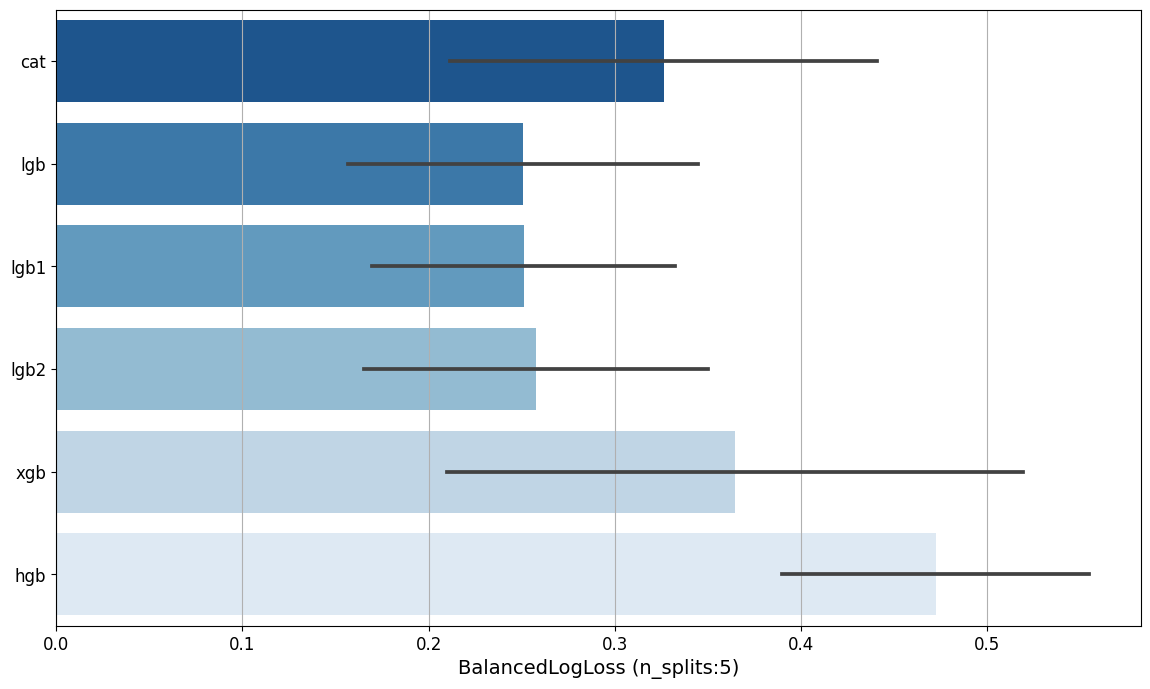

In [28]:
def plot_score_from_dict(score_dict, title = '', ascending =True):
    score_df = pd.melt(pd.DataFrame(score_dict))
    score_df = score_df.sort_values('value', ascending = ascending)

    plt.figure(figsize=(14, 8))
    sns.barplot(x='value', y='variable', data=score_df, palette='Blues_r', errorbar='sd')
    plt.xlabel(f'{title}', fontsize=14)
    plt.ylabel('')
    #plt.title(f'{title}', fontsize=18)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, axis='x')
    plt.show()

plot_score_from_dict(score_dict, title=f'BalancedLogLoss (n_splits:{n_splits})')

## Optuna Ensemble의 가중치

Ensemble BalancedLogLoss score 0.21187 ± 0.07295
--- Model Weights ---
xgb: 0.11172 ± 0.25504
lgb: 0.34159 ± 0.36006
lgb1: 0.36362 ± 0.38969
lgb2: 0.26830 ± 0.38590
hgb: 0.00082 ± 0.00126
cat: 0.05453 ± 0.19644

Stacking BalancedLogLoss score 0.16669 ± 0.07577



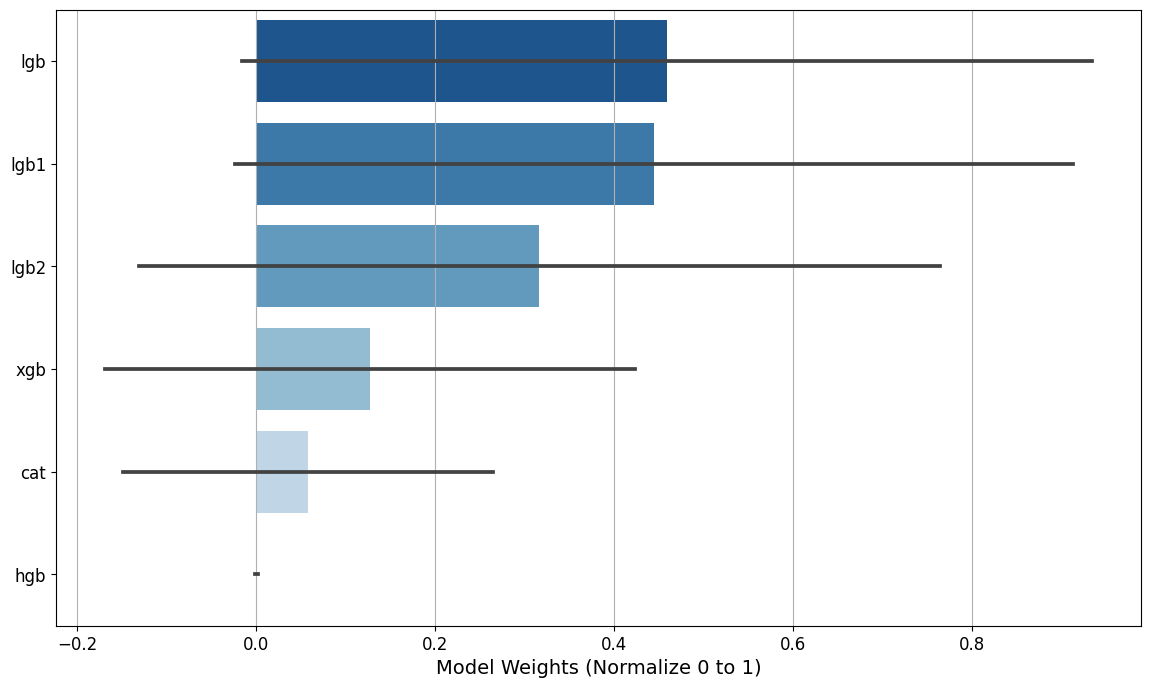

In [29]:
# 앙상블의 평균 LogLoss 점수 계산
mean_score = np.mean(ensemble_score)
std_score = np.std(ensemble_score)
print(f'Ensemble BalancedLogLoss score {mean_score:.5f} ± {std_score:.5f}')

# 각 모델에 대한 앙상블 가중치의 평균 및 표준편차를 출력
print('--- Model Weights ---')
mean_weights = np.mean(weights, axis = 0)
std_weights = np.std(weights, axis = 0)

for name, mean_weight, std_weight in zip(models.keys(), mean_weights, std_weights):
    print(f'{name}: {mean_weight:.5f} ± {std_weight:.5f}')
print('')

# 앙상블의 평균 LogLoss 계산
mean_score = np.mean(stack_scores)
std_score = np.std(stack_scores)
print(f'Stacking BalancedLogLoss score {mean_score:.5f} ± {std_score:.5f}\n')

normalize = [((weight - np.min(weight)) / (np.max(weight) - np.min(weight))).tolist() for weight in weights]
weight_dict = dict(zip(list(score_dict.keys()), np.array(normalize).T.tolist()))
plot_score_from_dict(weight_dict, title='Model Weights (Normalize 0 to 1)', ascending=False)

## 중요도 시각화

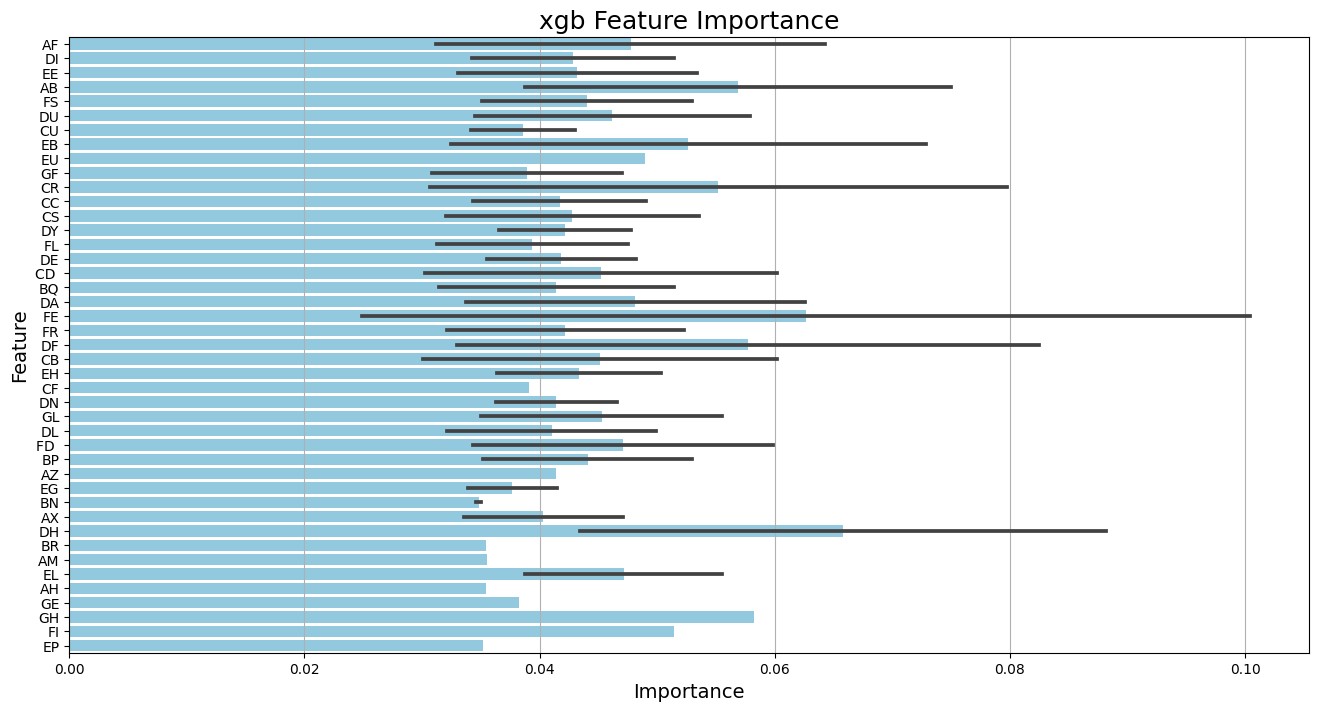

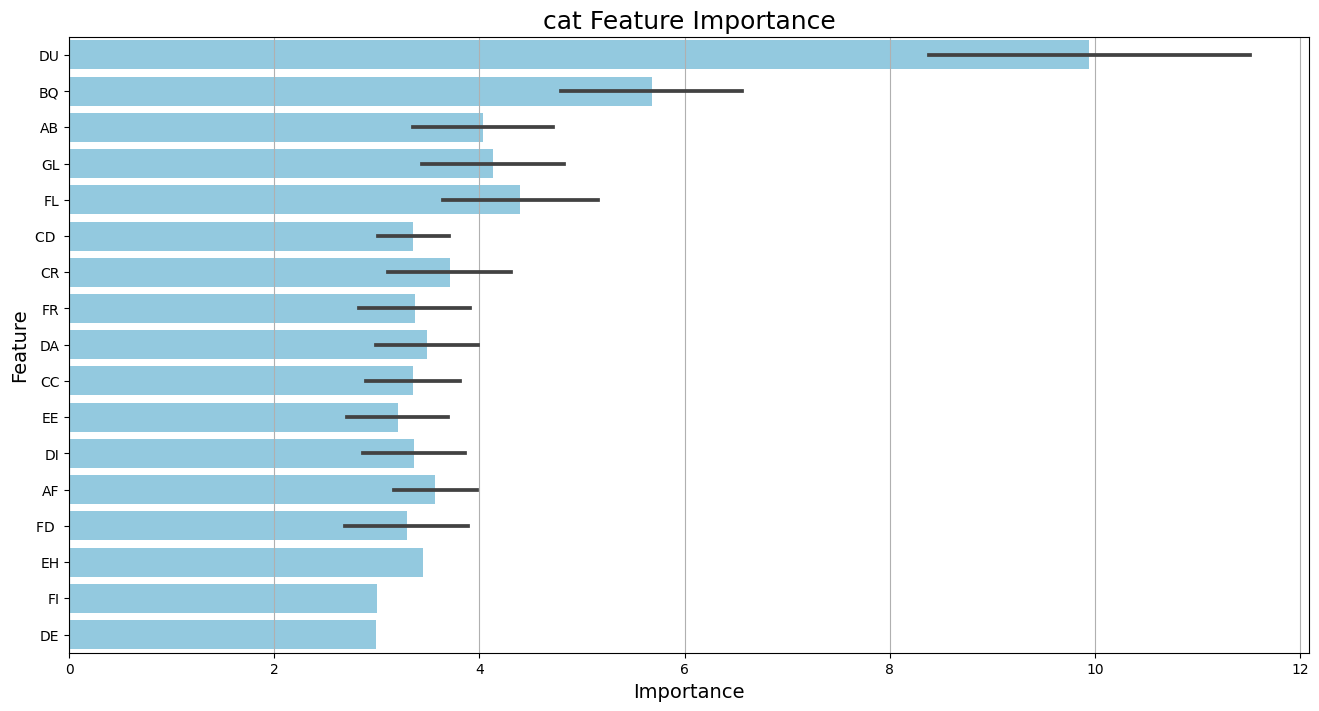

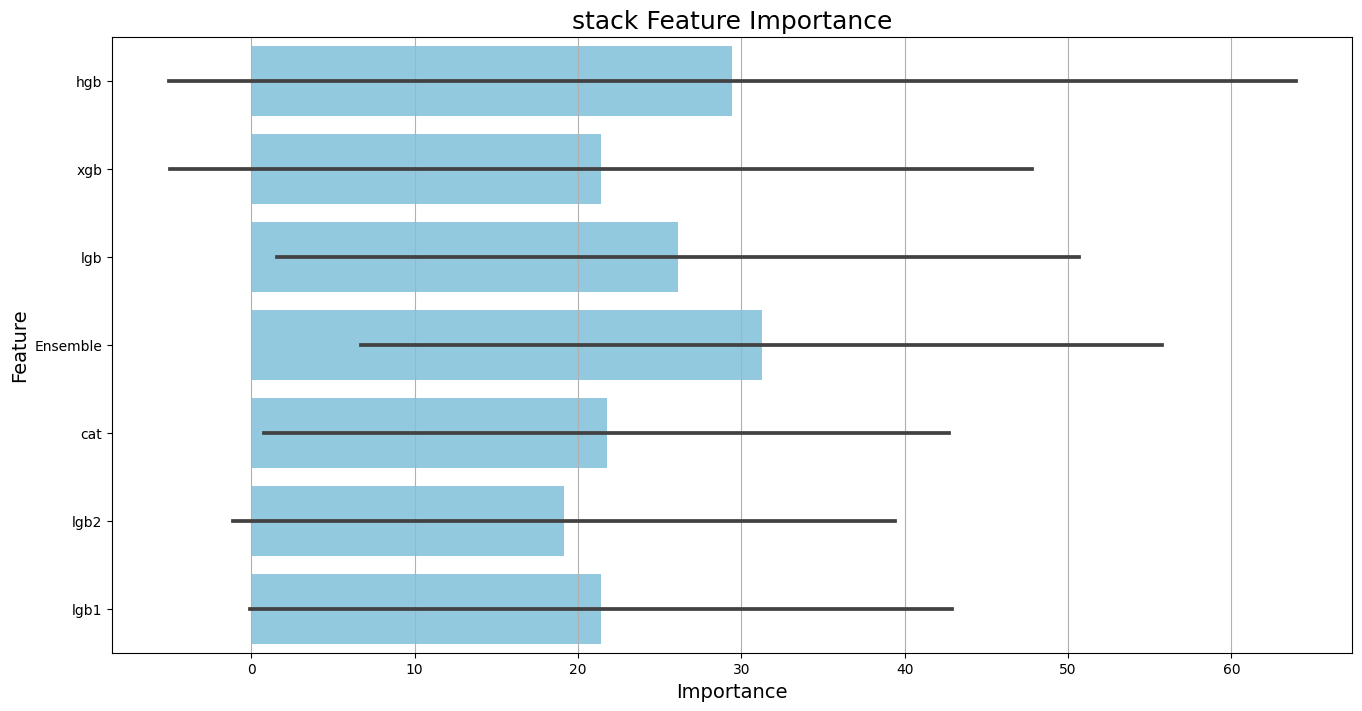

In [32]:
def visualize_importance(models, feature_cols, title, top = 8):
    importances = []
    feature_importance = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['importance'] = model.feature_importances_
        _df['feature'] = pd.Series(feature_cols)
        _df['fold'] = i
        _df = _df.sort_values('importance', ascending = False)
        _df = _df.head(top)
        feature_importance = pd.concat([feature_importance, _df], axis = 0, ignore_index = True)

    plt.figure(figsize=(16, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance, color='skyblue', errorbar='sd')
    plt.xlabel('Importance', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
    plt.title(f'{title} Feature Importance', fontsize=18)
    plt.grid(True, axis='x')
    plt.show()

for name, models in trained_models.items():
    if name in trained_models.keys():
        visualize_importance(models, list(X_train.columns), name)

visualize_importance(stack_models, list(score_dict.keys()) + ['Ensemble'], 'stack')

## OOF Evaluation (ROC-AUC)

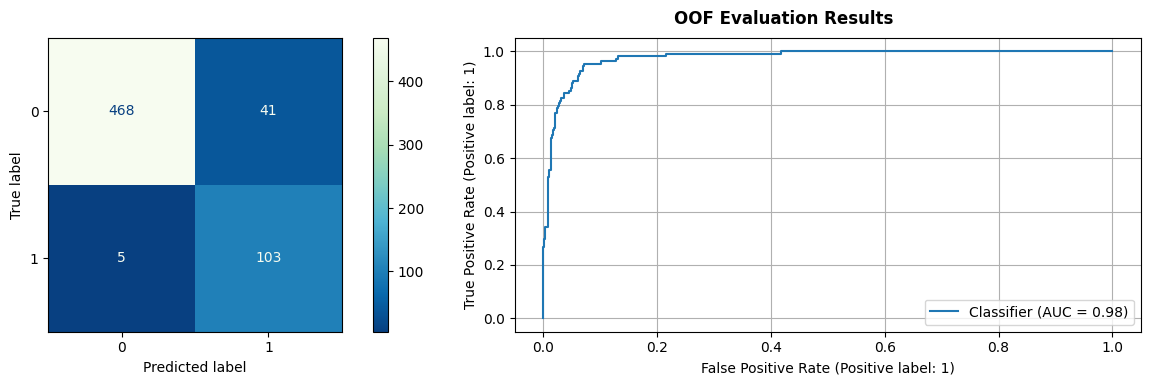

In [33]:
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def show_confusion_roc(oof, title = 'Model Evaluation Results'):
    f, ax = plt.subplots(1, 2, figsize = (13.3, 4))
    df = pd.DataFrame(np.stack([oof[0], oof[1]]), index = ['preds', 'target']).T
    cm = confusion_matrix(df.target, df.preds.ge(0.5).astype(int))
    cm_display = ConfusionMatrixDisplay(cm).plot(cmap='GnBu_r', ax=ax[0])
    ax[0].grid(False)
    RocCurveDisplay.from_predictions(df.target, df.preds, ax=ax[1])
    plt.suptitle(f'{title}', fontsize=12, fontweight='bold', y=0.95, x=0.72)
    plt.tight_layout()
    plt.grid()

show_confusion_roc(oof=[np.mean(oof_predss, axis=1), y_train], title=f'OOF Evaluation Results')

## 결과 생성

In [35]:
sub = pd.read_csv('sample_submission.csv')

sub['class_1'] = stack_test_predss
sub['class_0'] = 1 - stack_test_predss
sub.to_csv('submission.csv', index=False)
sub

Id   class_0   class_1
0  00eed32682bb  0.655858  0.344142
1  010ebe33f668  0.655858  0.344142
2  02fa521e1838  0.655858  0.344142
3  040e15f562a2  0.655858  0.344142
4  046e85c7cc7f  0.655858  0.344142